<a href="https://colab.research.google.com/github/Nuaninstein/F1-Performance-Analysis/blob/main/F1_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Performance Analysis of Formula 1 Drivers Using Machine Learning.**

# **Define Problem Statement, Objectives, Research Questions**

## **1.1 Problem Statement**

Most F1 studies focus on predicting race outcomes using machine learning, but these models often act as black boxes showing who wins without explaining why. This limits understanding of the true factors behind performance. As F1 evolves with new rules and technology, it’s unclear which factors remain consistently important. This research aims to fill that gap by using machine learning with interpretability tools to identify and explain key performance elements that drive success over time.

---
## **1.2 Research Objectives**

**RO1** To perform exploratory analysis to identify initial patterns and relationships among driver, team, and race variables that may influence race outcomes.

**RO2** To identify and analyse the most significant factors that influence driver success in Formula One.

**RO3** To implement machine learning algorithms that use identified attributes to test their ability to reproduce race outcomes.

**RO4** To perform exploratory analysis to identify initial patterns and relationships among  (to review)

---
## **1.3 Research Questions**
**RQ1** What patterns and relationships exist among drivers, team, and race variables that may influence Formula 1 race outcomes?

**RQ2** What are the most significant factors contributing to driver success in Formula One races?

**RQ3** How well can machine learning models reproduce actual race outcomes using the identified performance attributes?

**RQ4** Which performance factors and race conditions most influence Formula 1 race outcomes, and how effectively can machine learning models predict and explain these results?

In [ ]:
# SETUP ENVIRONMENT

!pip install pandas numpy matplotlib seaborn scikit-learn xgboost tqdm requests pyarrow openpyxl retry requests-cache openmeteo-requests --quiet

# ---- Core libraries ----
import os
import time
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
from datetime import datetime

# ---- Visualization ----
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Machine Learning & Preprocessing ----
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# ---- Open-Meteo API (for weather data) ----
import openmeteo_requests
import requests_cache
from retry import retry
from openmeteo_requests import Client

# ---- Setup API session ----
session = requests_cache.CachedSession('.cache', expire_after=3600)
client = openmeteo_requests.Client(session=session)

# ---- Plot and display settings ----
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# ---- Helper function: convert lap/qual times to seconds ----
def time_to_seconds(x):
    """Convert F1 time strings (e.g. '1:23.456') to seconds as float."""
    if pd.isna(x): return np.nan
    x = str(x)
    if ':' in x:
        parts = x.split(':')
        if len(parts) == 2:
            m, s = parts
            try: return float(m)*60 + float(s)
            except: return np.nan
        if len(parts) == 3:
            h, m, s = parts
            try: return float(h)*3600 + float(m)*60 + float(s)
            except: return np.nan
    try: return float(x)
    except: return np.nan

# ---- Confirm setup ----
print("✅ Environment ready!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.7/684.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.9 MB/s eta 0:00:00
✅ Environment ready!


# **Data Collection & Integration**


In [ ]:
# Data Integration + Geocoding (Add Latitude & Longitude)

import pandas as pd
import numpy as np
import requests
import time
from urllib.parse import quote

data_path = '/content/drive/MyDrive/F1_Project/Data/'

races = pd.read_csv(data_path + 'races.csv')
circuits = pd.read_csv(data_path + 'circuits.csv')

races['date'] = pd.to_datetime(races['date']).dt.strftime('%Y-%m-%d')
races = races.sort_values(['year','round']).reset_index(drop=True)
races = races.rename(columns={'name':'race_name'})

circuits = circuits.rename(columns={'name':'circuit_name'})
if 'lat' not in circuits.columns: circuits['lat'] = np.nan
if 'lon' in circuits.columns:
    pass
elif 'lng' in circuits.columns:
    circuits = circuits.rename(columns={'lng':'lon'})
else:
    circuits['lon'] = np.nan

def geocode_one(name, location, country):
    q = ", ".join([x for x in [location, country] if pd.notna(x) and str(x).strip()!='']) or str(name)
    url = f"https://geocoding-api.open-meteo.com/v1/search?name={quote(q)}&count=1"
    r = requests.get(url, timeout=30)
    if r.status_code != 200:
        return None, None
    j = r.json()
    res = j.get('results', [])
    if not res and name:
        url2 = f"https://geocoding-api.open-meteo.com/v1/search?name={quote(str(name))}&count=1"
        r2 = requests.get(url2, timeout=30)
        if r2.status_code != 200:
            return None, None
        j2 = r2.json()
        res = j2.get('results', [])
        if not res:
            return None, None
    return res[0].get('latitude'), res[0].get('longitude')

need_geo = circuits['lat'].isna() | circuits['lon'].isna()
geo_cache = {}
for idx, row in circuits[need_geo].iterrows():
    key = (row.get('circuit_name'), row.get('location'), row.get('country'))
    if key in geo_cache:
        lat, lon = geo_cache[key]
    else:
        time.sleep(0.2)
        lat, lon = geocode_one(*key)
        geo_cache[key] = (lat, lon)
    circuits.at[idx, 'lat'] = lat
    circuits.at[idx, 'lon'] = lon

races = races.merge(
    circuits[['circuitId','circuit_name','location','country','lat','lon']],
    on='circuitId',
    how='left'
)

races[['raceId','year','round','race_name','circuit_name','country','date','lat','lon']].head()

,raceId,year,round,race_name,circuit_name,country,date,lat,lon
0,833,1950,1,British Grand Prix,Silverstone Circuit,UK,1950-05-13,52.0786,-1.01694
1,834,1950,2,Monaco Grand Prix,Circuit de Monaco,Monaco,1950-05-21,43.7347,7.42056
2,835,1950,3,Indianapolis 500,Indianapolis Motor Speedway,USA,1950-05-30,39.7950,-86.23470
3,836,1950,4,Swiss Grand Prix,Circuit Bremgarten,Switzerland,1950-06-04,46.9589,7.40194
4,837,1950,5,Belgian Grand Prix,Circuit de Spa-Francorchamps,Belgium,1950-06-18,50.4372,5.97139


# **Weather Data Extraction**

In [ ]:
# Collect Weather Data (1950–2024)

import os, time, math, json, requests, pandas as pd
from tqdm import tqdm
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

out_path = "/content/drive/MyDrive/F1_Project/Data/weather_1950_2024.csv"

def make_session():
    s = requests.Session()
    retries = Retry(total=5, backoff_factor=1.5, status_forcelist=[429,500,502,503,504], raise_on_status=False)
    s.mount("https://", HTTPAdapter(max_retries=retries, pool_connections=100, pool_maxsize=100))
    s.headers.update({"User-Agent":"colab-f1-weather"})
    return s

def get_weather_for_date(session, lat, lon, date_str, timeout=60):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": date_str,
        "end_date": date_str,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max",
        "timezone": "UTC"
    }
    r = session.get(url, params=params, timeout=timeout)
    if r.status_code != 200:
        return None
    try:
        j = r.json()
    except:
        return None
    d = j.get("daily", {})
    if not d or not d.get("time"):
        return None
    return {
        "date": d["time"][0],
        "temp_max": (d.get("temperature_2m_max") or [None])[0],
        "temp_min": (d.get("temperature_2m_min") or [None])[0],
        "precipitation": (d.get("precipitation_sum") or [None])[0],
        "wind_speed_max": (d.get("wind_speed_10m_max") or [None])[0],
    }

existing = pd.read_csv(out_path) if os.path.exists(out_path) else pd.DataFrame(columns=[
    "raceId","season","round","race_name","circuit_name","country","date","temp_max","temp_min","precipitation","wind_speed_max"
])
done_ids = set(existing["raceId"].astype(int).tolist())

pending = races[~races["raceId"].isin(done_ids)].copy()
pending = pending[pd.notna(pending["lat"]) & pd.notna(pending["lon"]) & pd.notna(pending["date"])]

session = make_session()
rows = []

flush_every = 100
for i, (_, row) in enumerate(tqdm(pending.iterrows(), total=len(pending))):
    lat, lon, date_str = row["lat"], row["lon"], row["date"]
    try:
        w = get_weather_for_date(session, lat, lon, date_str)
    except requests.exceptions.RequestException:
        time.sleep(3)
        try:
            session = make_session()
            w = get_weather_for_date(session, lat, lon, date_str)
        except:
            w = None
    if w is not None:
        rows.append({
            "raceId": int(row["raceId"]),
            "season": int(row["year"]),
            "round": int(row["round"]),
            "race_name": row["race_name"],
            "circuit_name": row["circuit_name"],
            "country": row["country"],
            "date": w["date"],
            "temp_max": w["temp_max"],
            "temp_min": w["temp_min"],
            "precipitation": w["precipitation"],
            "wind_speed_max": w["wind_speed_max"]
        })
    time.sleep(0.25)
    if rows and (i+1) % flush_every == 0:
        chunk = pd.DataFrame(rows)
        existing = pd.concat([existing, chunk], ignore_index=True)
        existing.drop_duplicates(subset=["raceId"], inplace=True)
        existing.to_csv(out_path, index=False)
        rows = []

if rows:
    chunk = pd.DataFrame(rows)
    existing = pd.concat([existing, chunk], ignore_index=True)

existing.drop_duplicates(subset=["raceId"], inplace=True)
existing.to_csv(out_path, index=False)
out_path, existing.shape



0it [00:00, ?it/s]


('/content/drive/MyDrive/F1_Project/Data/weather_1950_2024.csv', (1125, 11))

#**Feature Engineering**

In [ ]:
# Feature Engineering

import pandas as pd
import numpy as np

data_path = '/content/drive/MyDrive/F1_Project/Data/'
weather_path = data_path + 'weather_1950_2024.csv'

races = pd.read_csv(data_path + 'races.csv')
circuits = pd.read_csv(data_path + 'circuits.csv')
drivers = pd.read_csv(data_path + 'drivers.csv')
constructors = pd.read_csv(data_path + 'constructors.csv')
results = pd.read_csv(data_path + 'results.csv')
qualifying = pd.read_csv(data_path + 'qualifying.csv')
pit_stops = pd.read_csv(data_path + 'pit_stops.csv')
lap_times = pd.read_csv(data_path + 'lap_times.csv')
weather = pd.read_csv(weather_path)

# -------- Standardization --------
races['date'] = pd.to_datetime(races['date'])
races = races.rename(columns={'name': 'race_name'})
circuits = circuits.rename(columns={'name': 'circuit_name'})
drivers['driver_name'] = (drivers['forename'].fillna('') + ' ' + drivers['surname'].fillna('')).str.strip()

# -------- Base Merge: results + race + circuit + driver + constructor --------
base = (
    results
    .merge(races[['raceId','year','round','circuitId','race_name','date']], on='raceId', how='left')
    .merge(circuits[['circuitId','circuit_name','location','country']], on='circuitId', how='left')
    .merge(drivers[['driverId','driver_name','nationality']], on='driverId', how='left')
    .merge(constructors[['constructorId','name']], on='constructorId', how='left')
)
base = base.rename(columns={'name': 'constructor_name'})

# -------- Convert qualifying time strings to seconds  --------
def time_to_seconds(x):
    if pd.isna(x): return np.nan
    x = str(x)
    if ':' in x:
        parts = x.split(':')
        if len(parts) == 2:  # mm:ss.sss
            m, s = parts
            try: return float(m) * 60 + float(s)
            except: return np.nan
        if len(parts) == 3:  # hh:mm:ss.sss
            h, m, s = parts
            try: return float(h) * 3600 + float(m) * 60 + float(s)
            except: return np.nan
    try: return float(x)
    except: return np.nan

# -------- Qualifying Features: best lap, gap to pole, qualifying position --------
qs = qualifying.copy()
qs['q1_s'] = qs['q1'].apply(time_to_seconds)
qs['q2_s'] = qs['q2'].apply(time_to_seconds)
qs['q3_s'] = qs['q3'].apply(time_to_seconds)
qs['best_qual_s'] = qs[['q1_s','q2_s','q3_s']].min(axis=1)

# Pole time per race
pole = qs.groupby('raceId', as_index=False)['best_qual_s'].min().rename(columns={'best_qual_s':'pole_s'})
qs = qs.merge(pole, on='raceId', how='left')
qs['qual_gap_to_pole_s'] = qs['best_qual_s'] - qs['pole_s']

qs_feat = qs[['raceId','driverId','constructorId','position','best_qual_s','qual_gap_to_pole_s']].rename(
    columns={'position': 'qual_position'}
)
base = base.merge(qs_feat, on=['raceId','driverId','constructorId'], how='left')

# -------- Driver Experience: number of prior race starts up to this race --------
base = base.sort_values(['driverId','date']).reset_index(drop=True)
base['driver_experience'] = base.groupby('driverId').cumcount()

# -------- Constructor Form: rolling mean of last 5 race points for the team --------
base = base.sort_values(['constructorId','date']).reset_index(drop=True)
base['constructor_form_5'] = (
    base.groupby('constructorId')['points']
        .rolling(window=5, min_periods=1).mean()
        .reset_index(level=0, drop=True)
)

# -------- In-Race Features  --------
pits = pit_stops.groupby(['raceId','driverId'], as_index=False).agg(inrace_pitstops=('stop','count'))
base = base.merge(pits, on=['raceId','driverId'], how='left')

laps = lap_times.groupby(['raceId','driverId'], as_index=False).agg(
    inrace_avg_lap_ms=('milliseconds','mean'),
    inrace_best_lap_ms=('milliseconds','min')
)
base = base.merge(laps, on=['raceId','driverId'], how='left')

# -------- Weather Join --------
weather['date'] = pd.to_datetime(weather['date'])
w_cols = ['raceId','temp_max','temp_min','precipitation','wind_speed_max']
base = base.merge(weather[w_cols], on='raceId', how='left')

# -------- Era Flags: capture regulation changes (2014 hybrid, 2022 ground-effect) --------
base['era_2014_plus'] = (base['year'] >= 2014).astype(int)
base['era_2022_plus'] = (base['year'] >= 2022).astype(int)

# -------- Final Cleanups --------
base['grid'] = base['grid'].replace({0: np.nan})  # grid=0 means unknown in dataset
base['finished_flag'] = (base['positionText'].astype(str).str.isnumeric()).astype(int)

# -------- Select and Save Engineered Features --------
keep_cols = [
    'raceId','year','round','date','country','circuit_name','race_name',
    'driverId','driver_name','constructorId','constructor_name','nationality',
    'grid','qual_position','best_qual_s','qual_gap_to_pole_s','driver_experience','constructor_form_5',
    'temp_max','temp_min','precipitation','wind_speed_max','era_2014_plus','era_2022_plus',
    'inrace_pitstops','inrace_avg_lap_ms','inrace_best_lap_ms',  # in-race (for explanation only)
    'positionOrder','points','finished_flag'                      # targets
]
fe = base[keep_cols].copy()

fe.to_parquet(data_path + 'engineered_features.parquet', index=False)


fe.head(30)



,raceId,year,round,date,country,circuit_name,race_name,driverId,driver_name,constructorId,constructor_name,nationality,grid,qual_position,best_qual_s,qual_gap_to_pole_s,driver_experience,constructor_form_5,temp_max,temp_min,precipitation,wind_speed_max,era_2014_plus,era_2022_plus,inrace_pitstops,inrace_avg_lap_ms,inrace_best_lap_ms,positionOrder,points,finished_flag
0,674,1968,8,1968-08-04,Germany,Nürburgring,German Grand Prix,360,Bruce McLaren,1,McLaren,New Zealander,16.0,NaN,NaN,NaN,84,0.000000,15.0,13.6,33.5,13.0,0,0,NaN,NaN,NaN,13,0.0,1
1,677,1968,11,1968-10-06,USA,Watkins Glen,United States Grand Prix,304,Denny Hulme,1,McLaren,New Zealander,5.0,NaN,NaN,NaN,36,0.000000,11.4,0.8,0.1,21.7,0,0,NaN,NaN,NaN,8,0.0,0
2,632,1971,1,1971-03-06,South Africa,Kyalami,South African Grand Prix,304,Denny Hulme,1,McLaren,New Zealander,7.0,NaN,NaN,NaN,60,0.333333,26.8,12.7,0.1,19.4,0,0,NaN,NaN,NaN,6,1.0,1
3,632,1971,1,1971-03-06,South Africa,Kyalami,South African Grand Prix,320,Peter Gethin,1,McLaren,British,11.0,NaN,NaN,NaN,7,0.250000,26.8,12.7,0.1,19.4,0,0,NaN,NaN,NaN,23,0.0,0
4,632,1971,1,1971-03-06,South Africa,Kyalami,South African Grand Prix,347,Jo Bonnier,1,McLaren,Swedish,23.0,NaN,NaN,NaN,104,0.200000,26.8,12.7,0.1,19.4,0,0,NaN,NaN,NaN,24,0.0,0
5,633,1971,2,1971-04-18,Spain,Montjuïc,Spanish Grand Prix,304,Denny Hulme,1,McLaren,New Zealander,9.0,NaN,NaN,NaN,61,0.600000,17.3,10.2,0.0,12.4,0,0,NaN,NaN,NaN,5,2.0,1
6,633,1971,2,1971-04-18,Spain,Montjuïc,Spanish Grand Prix,320,Peter Gethin,1,McLaren,British,7.0,NaN,NaN,NaN,8,0.600000,17.3,10.2,0.0,12.4,0,0,NaN,NaN,NaN,8,0.0,1
7,634,1971,3,1971-05-23,Monaco,Circuit de Monaco,Monaco Grand Prix,304,Denny Hulme,1,McLaren,New Zealander,6.0,NaN,NaN,NaN,62,1.000000,16.9,11.0,8.6,10.1,0,0,NaN,NaN,NaN,4,3.0,1
8,634,1971,3,1971-05-23,Monaco,Circuit de Monaco,Monaco Grand Prix,320,Peter Gethin,1,McLaren,British,14.0,NaN,NaN,NaN,9,1.000000,16.9,11.0,8.6,10.1,0,0,NaN,NaN,NaN,15,0.0,0
9,635,1971,4,1971-06-20,Netherlands,Circuit Park Zandvoort,Dutch Grand Prix,304,Denny Hulme,1,McLaren,New Zealander,14.0,NaN,NaN,NaN,63,1.000000,14.5,11.0,6.4,34.6,0,0,NaN,NaN,NaN,12,0.0,1


#**Attribute Selection**

In [ ]:
# Attribute Selection (Pre-Race, Prevent Leakage)

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

data_path = '/content/drive/MyDrive/F1_Project/Data/'
fe = pd.read_parquet(data_path + 'engineered_features.parquet')

# -------- target and bookkeeping columns --------
target = 'positionOrder'

# -------- Leakage columns: values only known during/after race --------
leak_cols = ['points','inrace_pitstops','inrace_avg_lap_ms','inrace_best_lap_ms']

# -------- Meta Columns --------
meta_cols = ['raceId','date','race_name','circuit_name','country','driver_name','constructor_name']
id_cols = ['driverId','constructorId','year','round']

# Candidate PRE-RACE features
pre_race_candidates = [
    'grid','qual_position','best_qual_s','qual_gap_to_pole_s',
    'driver_experience','constructor_form_5',
    'temp_max','temp_min','precipitation','wind_speed_max',
    'era_2014_plus','era_2022_plus'
]

# -------- drop leakage, keep rows with target --------
df = fe.drop(columns=leak_cols, errors='ignore').copy()
df = df[df[target].notna()].copy()

# -------- assemble modeling frame: meta + ids + features + target --------
X_pre = df[meta_cols + id_cols + pre_race_candidates + [target]].copy()

# Ensure numeric dtype for numeric features
for c in pre_race_candidates:
    if X_pre[c].dtype.kind in 'biufc':
        X_pre[c] = X_pre[c].astype(float)

# -------- Impute missing values (median -> robust against outliers) --------
num_imputer = SimpleImputer(strategy='median')
Xn = pd.DataFrame(
    num_imputer.fit_transform(X_pre[pre_race_candidates]),
    columns=pre_race_candidates,
    index=X_pre.index
)

# -------- Remove zero-variance features (no information) --------
vt = VarianceThreshold(threshold=0.0)
mask = vt.fit(Xn).get_support()
Xn = Xn.loc[:, Xn.columns[mask]]

# -------- Remove highly correlated features (>0.95) to reduce redundancy --------
corr = Xn.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
Xn = Xn.drop(columns=to_drop)

# -------- Reattach target and meta/ids --------
y = X_pre[target].astype(int)
out_pre = pd.concat(
    [X_pre[meta_cols + id_cols].reset_index(drop=True),
     Xn.reset_index(drop=True),
     y.reset_index(drop=True)],
    axis=1
)


out_pre.to_parquet(data_path + 'pre_race_dataset.parquet', index=False)
pd.DataFrame({'kept_feature': Xn.columns}).to_csv(data_path + 'pre_race_features_kept.csv', index=False)

# Sanity Check
out_pre.shape


(26759, 24)

Shape: (26759, 30)
raceId                         int64
year                           int64
round                          int64
date                  datetime64[ns]
country                       object
circuit_name                  object
race_name                     object
driverId                       int64
driver_name                   object
constructorId                  int64
constructor_name              object
nationality                   object
grid                         float64
qual_position                float64
best_qual_s                  float64
qual_gap_to_pole_s           float64
driver_experience              int64
constructor_form_5           float64
temp_max                     float64
temp_min                     float64
precipitation                float64
wind_speed_max               float64
era_2014_plus                  int64
era_2022_plus                  int64
inrace_pitstops              float64
inrace_avg_lap_ms            float64
inrace_best_lap_ms 

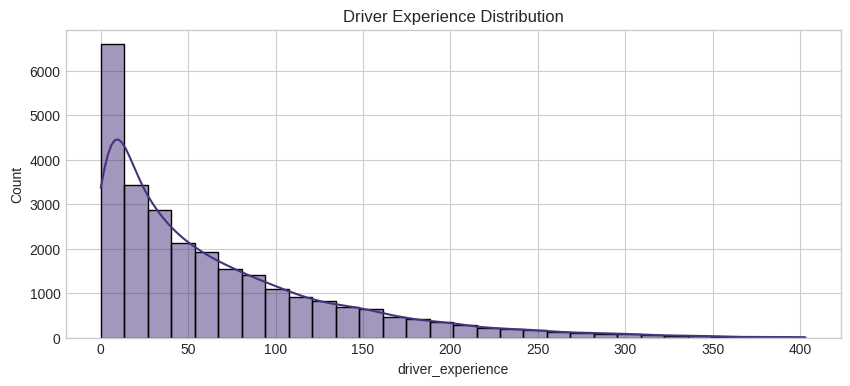

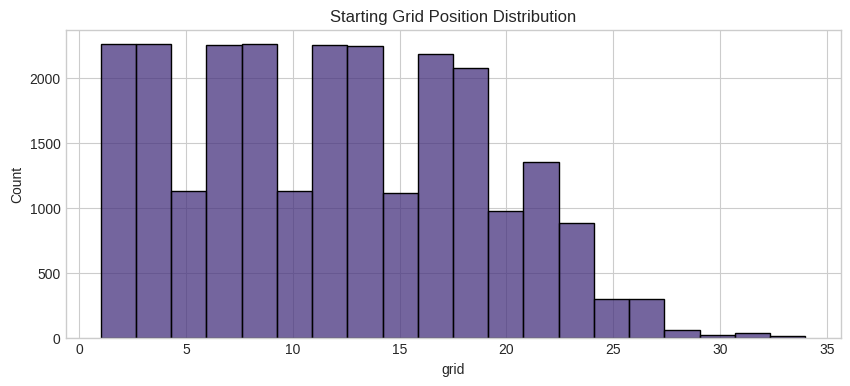

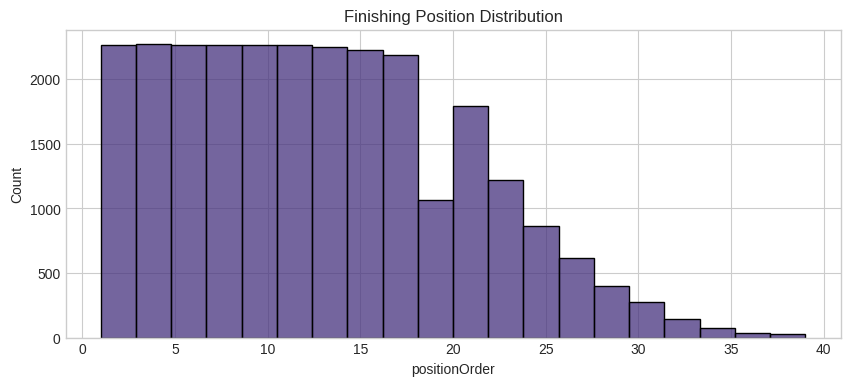

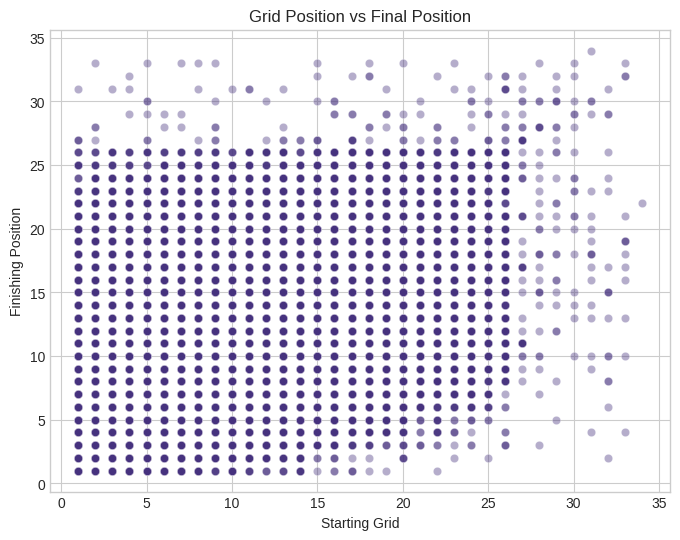

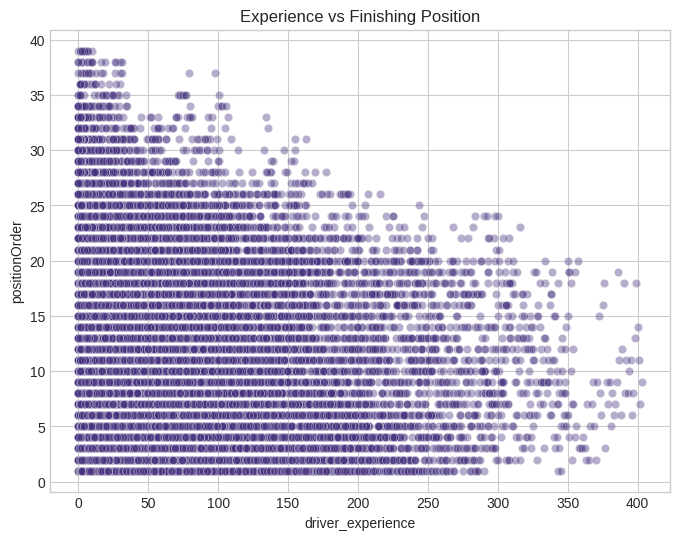

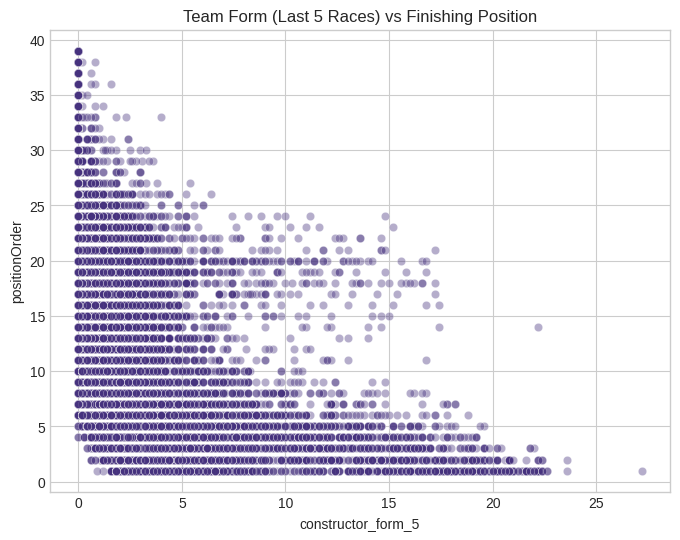

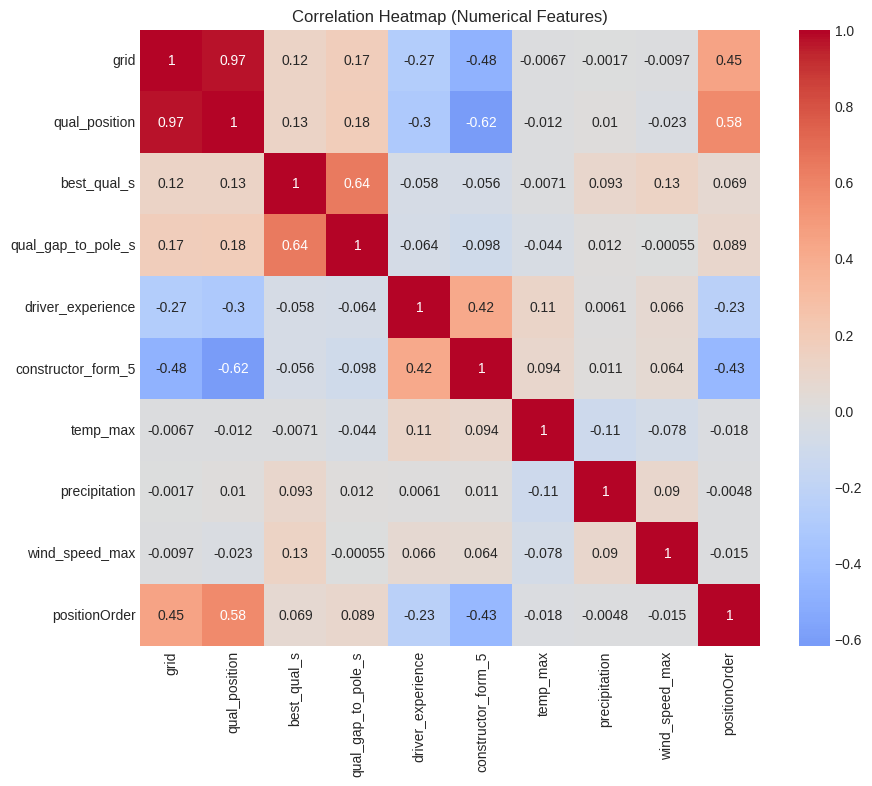

/tmp/ipython-input-4056080527.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fe.groupby(['era','constructor_name'])['positionOrder']


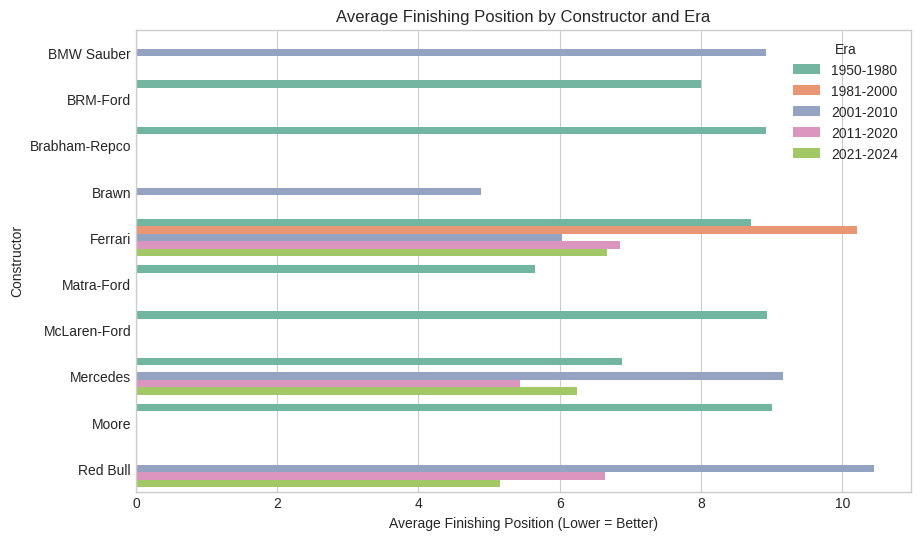

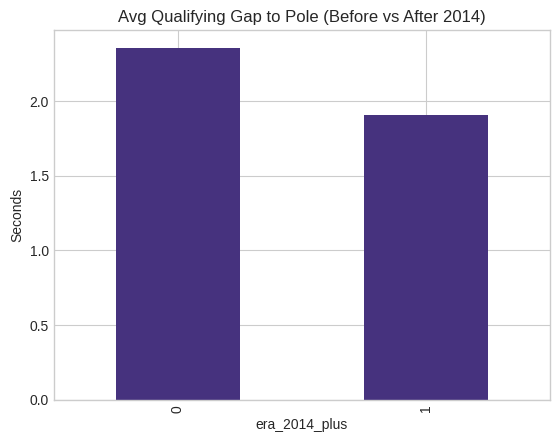

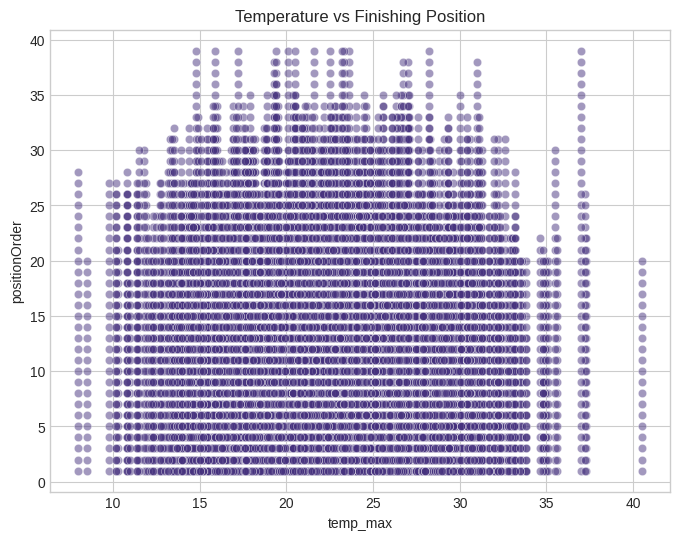

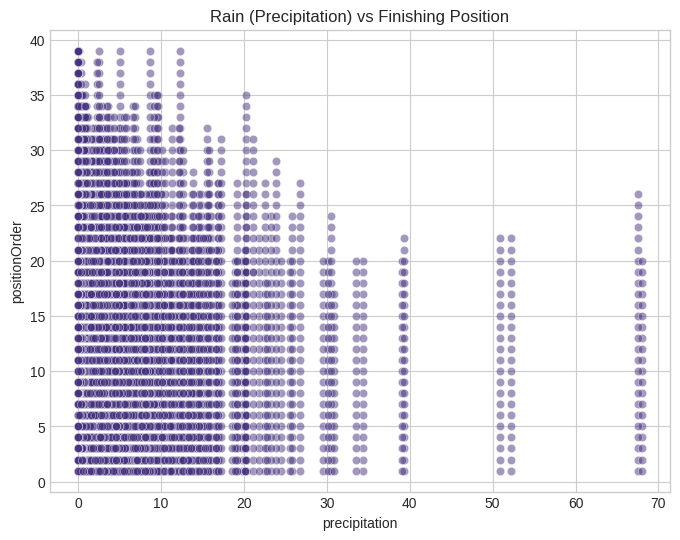

,positionOrder
constructor_form_5,-0.433847
driver_experience,-0.233946
temp_max,-0.018353
wind_speed_max,-0.015307
precipitation,-0.004778
best_qual_s,0.069344
qual_gap_to_pole_s,0.088605
grid,0.446289
qual_position,0.576216
positionOrder,1.000000


In [ ]:
# Objective 1: To perform exploratory analysis to identify initial patterns and relationships among driver, team, and race variables that may influence race outcomes.
# EDA Visualization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '/content/drive/MyDrive/F1_Project/Data/'
fe = pd.read_parquet(data_path + 'engineered_features.parquet')

# -------- Sanity Check --------
print("Shape:", fe.shape)
print(fe.dtypes)
fe.describe().T

# -------- Distribution of Key Variables --------
plt.figure(figsize=(10,4))
sns.histplot(fe['driver_experience'], bins=30, kde=True)
plt.title('Driver Experience Distribution')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(fe['grid'], bins=20, kde=False)
plt.title('Starting Grid Position Distribution')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(fe['positionOrder'], bins=20, kde=False)
plt.title('Finishing Position Distribution')
plt.show()

# -------- Relationship between Pre-Race Factors and Performance --------
plt.figure(figsize=(8,6))
sns.scatterplot(x='grid', y='positionOrder', data=fe, alpha=0.4)
plt.title('Grid Position vs Final Position')
plt.xlabel('Starting Grid')
plt.ylabel('Finishing Position')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='driver_experience', y='positionOrder', data=fe, alpha=0.4)
plt.title('Experience vs Finishing Position')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='constructor_form_5', y='positionOrder', data=fe, alpha=0.4)
plt.title('Team Form (Last 5 Races) vs Finishing Position')
plt.show()

# -------- Correlation Heatmap --------
num_cols = [
    'grid','qual_position','best_qual_s','qual_gap_to_pole_s',
    'driver_experience','constructor_form_5','temp_max','precipitation','wind_speed_max','positionOrder'
]
corr = fe[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

# -------- Group-Level Insights --------

# Contructors Performance by Era
fe['era'] = pd.cut(fe['year'],
                   bins=[1950, 1980, 2000, 2010, 2020, 2030],
                   labels=['1950-1980','1981-2000','2001-2010','2011-2020','2021-2024'])

era_team = (
    fe.groupby(['era','constructor_name'])['positionOrder']
      .mean()
      .reset_index()
)

top_teams = (
    era_team.groupby('constructor_name')['positionOrder']
      .mean()
      .nsmallest(10)
      .index
)

filtered = era_team[era_team['constructor_name'].isin(top_teams)]

plt.figure(figsize=(10,6))
sns.barplot(data=filtered, x='positionOrder', y='constructor_name', hue='era', palette='Set2')
plt.title('Average Finishing Position by Constructor and Era')
plt.xlabel('Average Finishing Position (Lower = Better)')
plt.ylabel('Constructor')
plt.legend(title='Era')
plt.show()


# -------- Average qualifying gap per era --------
era_gap = fe.groupby('era_2014_plus')['qual_gap_to_pole_s'].mean()
era_gap.plot(kind='bar', title='Avg Qualifying Gap to Pole (Before vs After 2014)')
plt.ylabel('Seconds')
plt.show()

# -------- Weather Impact Exploration --------
plt.figure(figsize=(8,6))
sns.scatterplot(x='temp_max', y='positionOrder', data=fe, alpha=0.5)
plt.title('Temperature vs Finishing Position')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='precipitation', y='positionOrder', data=fe, alpha=0.5)
plt.title('Rain (Precipitation) vs Finishing Position')
plt.show()

# -------- Statistical Summary --------
corr_target = corr['positionOrder'].sort_values()
corr_target




# **Data Splitting**


In [ ]:
# Time-aware Data Splitting
# Train models on older seasons, tune on 2023, test on unseen 2024.

import pandas as pd
from sklearn.model_selection import train_test_split

data_path = '/content/drive/MyDrive/F1_Project/Data/'
df = pd.read_parquet(data_path + 'pre_race_dataset.parquet')

# -------- Select Numeric + Target Features for Modeling --------
target = 'positionOrder'
feature_cols = [
    'grid','qual_position','best_qual_s','qual_gap_to_pole_s',
    'driver_experience','constructor_form_5',
    'temp_max','temp_min','precipitation','wind_speed_max',
    'era_2014_plus','era_2022_plus'
]

X = df[feature_cols].copy()
y = df[target].astype(int)
meta = df[['raceId','year','round','driver_name','constructor_name']]

# -------- Time-Aware Split --------
train_mask = df['year'] <= 2022
val_mask   = df['year'] == 2023
test_mask  = df['year'] == 2024

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

print(f"Train set: {X_train.shape[0]} samples ({df[train_mask]['year'].min()}-{df[train_mask]['year'].max()})")
print(f"Validation set: {X_val.shape[0]} samples (2023)")
print(f"Test set: {X_test.shape[0]} samples (2024)")

# -------- Save --------
X_train.to_parquet(data_path + 'X_train.parquet', index=False)
y_train.to_frame().to_parquet(data_path + 'y_train.parquet', index=False)
X_val.to_parquet(data_path + 'X_val.parquet', index=False)
y_val.to_frame().to_parquet(data_path + 'y_val.parquet', index=False)
X_test.to_parquet(data_path + 'X_test.parquet', index=False)
y_test.to_frame().to_parquet(data_path + 'y_test.parquet', index=False)


Train set: 25840 samples (1950-2022)
Validation set: 440 samples (2023)
Test set: 479 samples (2024)


In [ ]:

def split_summary(df, mask, split_name):
    years = df.loc[mask, "year"]
    races = df.loc[mask, "raceId"].nunique() if "raceId" in df.columns else None
    obs   = int(mask.sum())

    if years.nunique() == 1:
        season_text = str(int(years.iloc[0])) if len(years) > 0 else "-"
    else:
        season_text = f"{int(years.min())}–{int(years.max())}"

    return {
        "Evaluation Split": split_name,
        "Seasons Covered": season_text,
        "Number of Races": races,
        "Driver–Race Observations": obs
    }

# Ensure these masks exist (you already have them)
# train_mask = df["year"] <= 2022
# val_mask   = df["year"] == 2023
# test_mask  = df["year"] == 2024

rows = [
    split_summary(df, train_mask, "Training"),
    split_summary(df, val_mask, "Validation"),
    split_summary(df, test_mask, "Test"),
]

# Total row
total_row = {
    "Evaluation Split": "Total",
    "Seasons Covered": f"{int(df['year'].min())}–{int(df['year'].max())}",
    "Number of Races": df["raceId"].nunique() if "raceId" in df.columns else None,
    "Driver–Race Observations": int(df.shape[0]),
}
rows.append(total_row)

table_4_1 = pd.DataFrame(rows)
table_4_1


,Evaluation Split,Seasons Covered,Number of Races,Driver–Race Observations
0,Training,1950–2022,1079,25840
1,Validation,2023,22,440
2,Test,2024,24,479
3,Total,1950–2024,1125,26759


# Checking Pipeline

In [ ]:
# Checking Pipeline

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

data_path = '/content/drive/MyDrive/F1_Project/Data/'
X_train_raw = pd.read_parquet(data_path + 'X_train.parquet')

num_cols = X_train_raw.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X_train_raw.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler(with_mean=False))
        ]), num_cols),
        ('cat', Pipeline([
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), cat_cols)
    ]
)

lr_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=2000))
])

rf_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(random_state=42))
])

xgb_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', XGBRegressor(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=42
    ))
])

print("LR pipeline steps:", list(lr_pipe.named_steps.keys()))
print("RF pipeline steps:", list(rf_pipe.named_steps.keys()))
print("XGB pipeline steps:", list(xgb_pipe.named_steps.keys()))



Numeric columns: 12
Categorical columns: 0
LR pipeline steps: ['preprocess', 'model']
RF pipeline steps: ['preprocess', 'model']
XGB pipeline steps: ['preprocess', 'model']


# **Model Development Hyperparameter Tuning**


In [ ]:
data_path = '/content/drive/MyDrive/F1_Project/Data/'

X_train = pd.read_parquet(data_path + 'X_train.parquet')
y_train = pd.read_parquet(data_path + 'y_train.parquet')['positionOrder']
X_val   = pd.read_parquet(data_path + 'X_val.parquet')
y_val   = pd.read_parquet(data_path + 'y_val.parquet')['positionOrder']
X_test  = pd.read_parquet(data_path + 'X_test.parquet')
y_test  = pd.read_parquet(data_path + 'y_test.parquet')['positionOrder']

print(X_train.shape, X_val.shape, X_test.shape)

(25840, 12) (440, 12) (479, 12)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")
sns.set_palette("Set2")

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["figure.dpi"] = 110


## Model 1: Logistic Regression


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best LR params: {'clf__C': 0.1, 'clf__class_weight': None}
Best LR CV MAE: 6.047340430899406


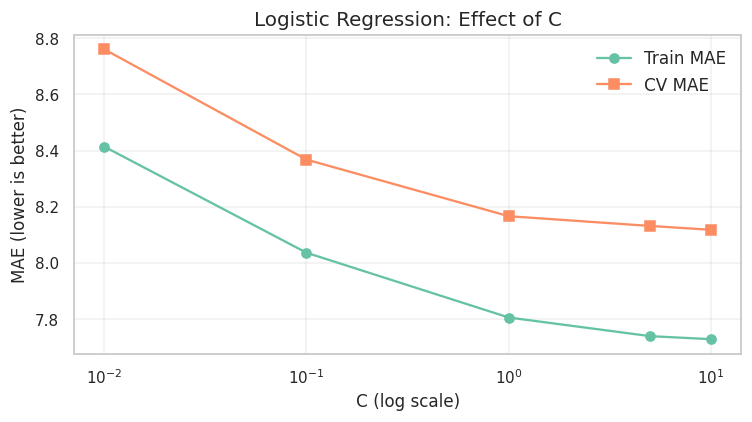

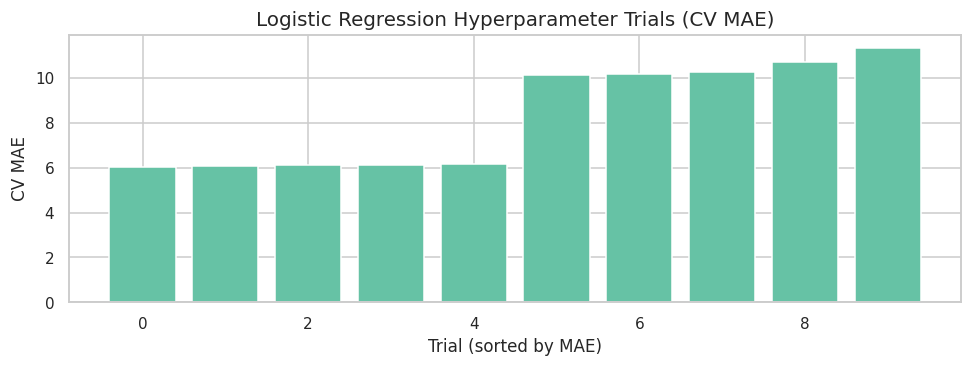

Train  MAE=5.806, RMSE=7.958
Val    MAE=3.311, RMSE=4.772
Test   MAE=2.747, RMSE=4.085
Race-wise metrics skipped (probably raceId files or helper not loaded). name 'racewise_spearman' is not defined


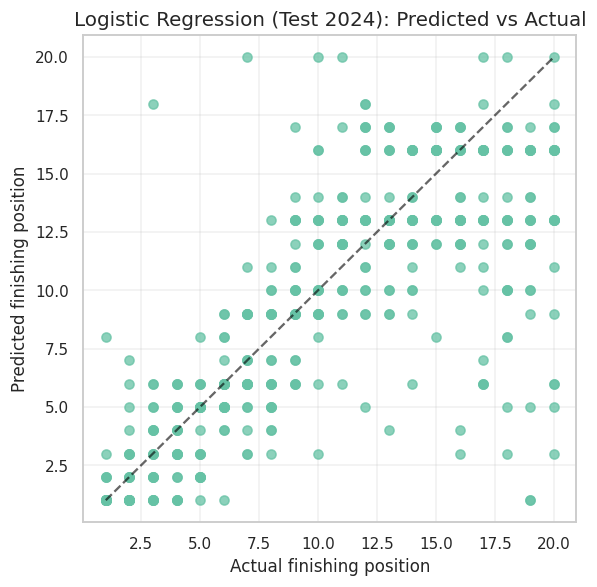

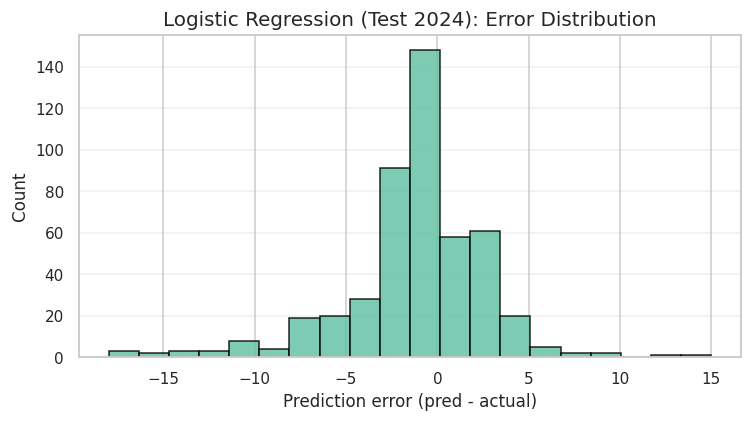

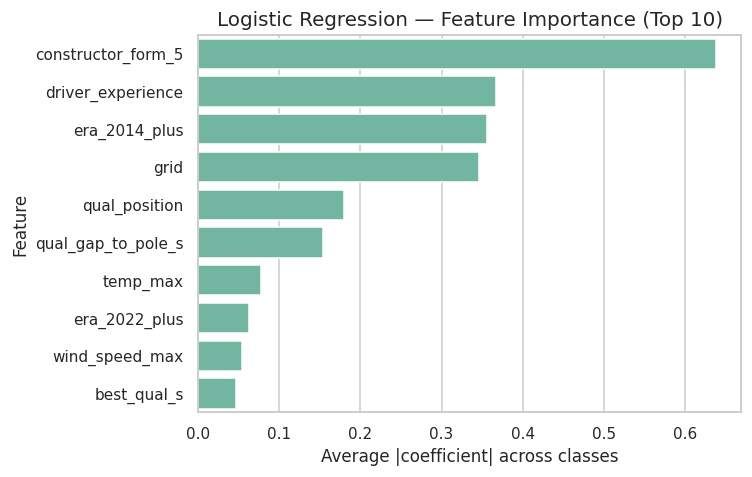

In [ ]:
# LOGISTIC REGRESSION

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

data_path = '/content/drive/MyDrive/F1_Project/Data/'
feature_names = X_train.columns

# For MAE / RMSE
def mae_rmse_simple(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return float(mae), float(rmse)

# Pipeline + hyperparameter search
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        max_iter=2000,
        multi_class='multinomial',
        n_jobs=-1
    ))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1.0, 5.0, 10.0],
    'clf__class_weight': [None, 'balanced']
}

lr_search = GridSearchCV(
    estimator=lr_pipe,
    param_grid=param_grid_lr,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_

print("Best LR params:", lr_search.best_params_)
print("Best LR CV MAE:", -lr_search.best_score_)

# Tuning behaviour: C vs MAE
lr_results = pd.DataFrame(lr_search.cv_results_)
lr_results['mean_val_mae'] = -lr_results['mean_test_score']
lr_results['mean_train_mae'] = -lr_results['mean_train_score']

# Need C values as floats for plotting
lr_results['C'] = lr_results['param_clf__C'].astype(float)

pivot_c = lr_results.groupby('C')[['mean_val_mae','mean_train_mae']].mean().sort_index()

plt.figure(figsize=(7,4))
plt.plot(pivot_c.index, pivot_c['mean_train_mae'], marker='o', label='Train MAE')
plt.plot(pivot_c.index, pivot_c['mean_val_mae'], marker='s', label='CV MAE')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('MAE (lower is better)')
plt.title('Logistic Regression: Effect of C')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# All trials sorted by MAE (experiment overview)
lr_results_sorted = lr_results.sort_values('mean_val_mae')
plt.figure(figsize=(9,3.5))
plt.bar(range(len(lr_results_sorted)), lr_results_sorted['mean_val_mae'])
plt.xlabel('Trial (sorted by MAE)')
plt.ylabel('CV MAE')
plt.title('Logistic Regression Hyperparameter Trials (CV MAE)')
plt.tight_layout()
plt.show()

# Metrics on Train / Val / Test
lr_train_pred = best_lr.predict(X_train)
lr_val_pred   = best_lr.predict(X_val)
lr_test_pred  = best_lr.predict(X_test)

train_mae, train_rmse = mae_rmse_simple(y_train, lr_train_pred)
val_mae, val_rmse     = mae_rmse_simple(y_val, lr_val_pred)
test_mae, test_rmse   = mae_rmse_simple(y_test, lr_test_pred)

print(f"Train  MAE={train_mae:.3f}, RMSE={train_rmse:.3f}")
print(f"Val    MAE={val_mae:.3f}, RMSE={val_rmse:.3f}")
print(f"Test   MAE={test_mae:.3f}, RMSE={test_rmse:.3f}")

try:
    race_val  = pd.read_parquet(data_path + 'raceId_val.parquet')['raceId'].values
    race_test = pd.read_parquet(data_path + 'raceId_test.parquet')['raceId'].values

    val_rho  = racewise_spearman(y_val,  lr_val_pred,  race_val)
    test_rho = racewise_spearman(y_test, lr_test_pred, race_test)
    print(f"Val   Spearman ρ={val_rho:.3f}")
    print(f"Test  Spearman ρ={test_rho:.3f}")
except Exception as e:
    print("Race-wise metrics skipped (probably raceId files or helper not loaded).", e)

# Predicted vs actual (Test)
plt.figure(figsize=(5.5,5.5))
plt.scatter(y_test, lr_test_pred, alpha=0.75)
mn = min(y_test.min(), lr_test_pred.min())
mx = max(y_test.max(), lr_test_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='black', alpha=0.6)
plt.xlabel('Actual finishing position')
plt.ylabel('Predicted finishing position')
plt.title('Logistic Regression (Test 2024): Predicted vs Actual')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Error distribution on Test
errors = lr_test_pred - y_test
plt.figure(figsize=(7,4))
plt.hist(errors, bins=20, edgecolor='black', alpha=0.85)
plt.xlabel('Prediction error (pred - actual)')
plt.ylabel('Count')
plt.title('Logistic Regression (Test 2024): Error Distribution')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Coefficient-based "feature importance"
clf = best_lr.named_steps['clf']
coef_matrix = clf.coef_
coef_importance = np.mean(np.abs(coef_matrix), axis=0)

lr_importances = pd.Series(coef_importance, index=feature_names).sort_values(ascending=False)
topn_lr = lr_importances.head(10)

plt.figure(figsize=(7,4.5))
sns.barplot(x=topn_lr.values, y=topn_lr.index)
plt.xlabel('Average |coefficient| across classes')
plt.ylabel('Feature')
plt.title('Logistic Regression — Feature Importance (Top 10)')
plt.tight_layout()
plt.show()




### **INTERPRETATION**


- Logistic Regression used as a **baseline linear model**.
- Hyperparameter **C** tuned using GridSearchCV (best: C = 0.1).
- Performance (2024 test set):
  - MAE ≈ 2.7 positions, RMSE ≈ 4.1.
- Predicted vs Actual scatter shows large spread → LR struggles with non-linear race dynamics and extreme outcomes.
- Error distribution roughly centred at 0, with some large tails due to unpredictable events (DNFs, safety cars, strategy).
- Top features (by coefficient magnitude):
  - constructor_form_5, driver_experience, grid / qual_position, era indicators, qualifying gap, and some weather variables.
- Conclusion: LR is **interpretable but underperforms** vs tree-based models, motivating the use of Random Forest and XGBoost.


## Model 2: Random Forest

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'max_depth': 10}
Best RF CV MAE: 4.83327063935926


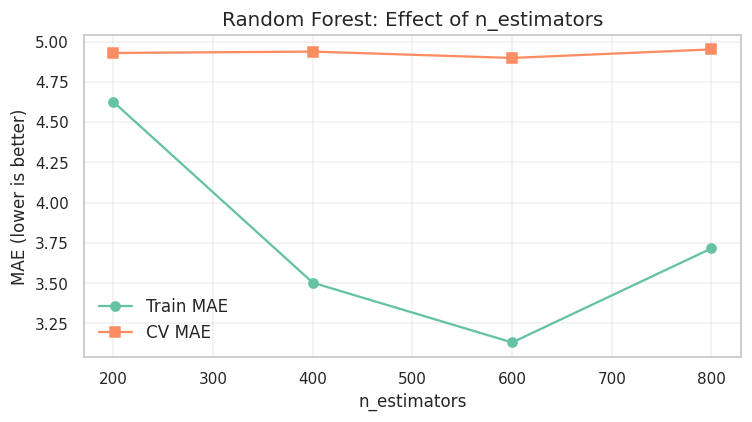

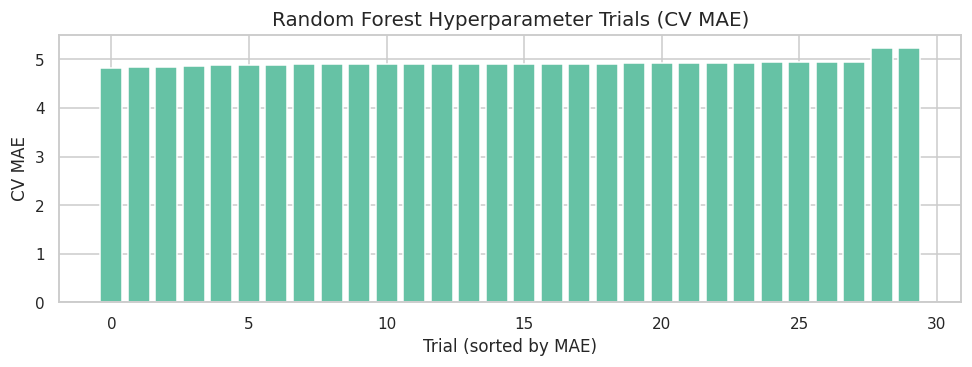

Train  MAE=4.352, RMSE=5.369
Val    MAE=3.118, RMSE=4.075
Test   MAE=2.738, RMSE=3.626
Race-wise metrics skipped (probably raceId files not loaded yet). name 'racewise_spearman' is not defined


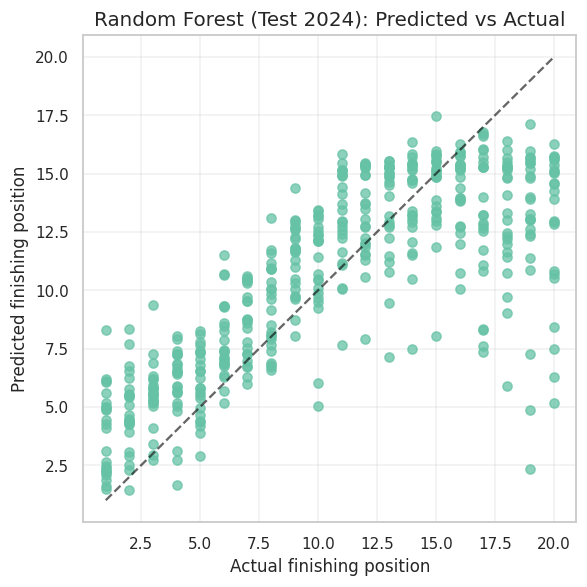

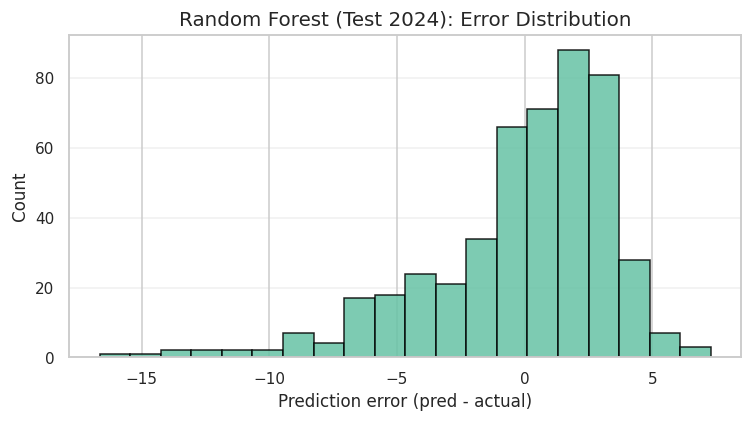

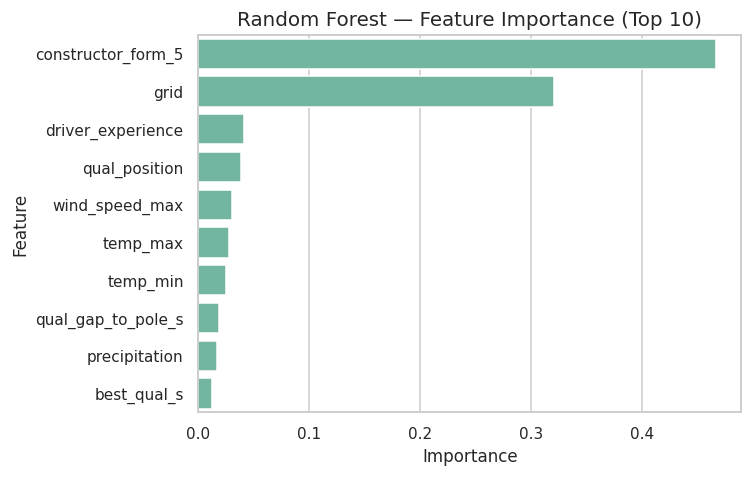

In [ ]:
# RANDOM FOREST — MODEL DEVELOPMENT (TUNING + VISUALS)

import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr

data_path = '/content/drive/MyDrive/F1_Project/Data/'
feature_names = X_train.columns

# For MAE / RMSE
def mae_rmse_simple(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return float(mae), float(rmse)

# Base RF model + hyperparameter search
rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

param_dist_rf = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.7]
}

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=30,                          #reduce this if runtime takes too long
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    return_train_score=True
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_


print("Best RF params:", rf_search.best_params_)
print("Best RF CV MAE:", -rf_search.best_score_)

# Learning-style curve: train vs CV MAE vs n_estimators
rf_results = pd.DataFrame(rf_search.cv_results_)
rf_results['mean_val_mae'] = -rf_results['mean_test_score']
rf_results['mean_train_mae'] = -rf_results['mean_train_score']

# pick out effect of n_estimators (average other params)
pivot_mae = rf_results.groupby('param_n_estimators')[['mean_val_mae','mean_train_mae']].mean()

plt.figure(figsize=(7,4))
plt.plot(pivot_mae.index, pivot_mae['mean_train_mae'], marker='o', label='Train MAE')
plt.plot(pivot_mae.index, pivot_mae['mean_val_mae'], marker='s', label='CV MAE')
plt.xlabel('n_estimators')
plt.ylabel('MAE (lower is better)')
plt.title('Random Forest: Effect of n_estimators')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Also show full trials sorted by MAE (like experiment log)
rf_results_sorted = rf_results.sort_values('mean_val_mae')
plt.figure(figsize=(9,3.5))
plt.bar(range(len(rf_results_sorted)), rf_results_sorted['mean_val_mae'])
plt.xlabel('Trial (sorted by MAE)')
plt.ylabel('CV MAE')
plt.title('Random Forest Hyperparameter Trials (CV MAE)')
plt.tight_layout()
plt.show()

# Metrics on Train / Val / Test
rf_train_pred = best_rf.predict(X_train)
rf_val_pred   = best_rf.predict(X_val)
rf_test_pred  = best_rf.predict(X_test)

train_mae, train_rmse = mae_rmse_simple(y_train, rf_train_pred)
val_mae, val_rmse     = mae_rmse_simple(y_val, rf_val_pred)
test_mae, test_rmse   = mae_rmse_simple(y_test, rf_test_pred)

print(f"Train  MAE={train_mae:.3f}, RMSE={train_rmse:.3f}")
print(f"Val    MAE={val_mae:.3f}, RMSE={val_rmse:.3f}")
print(f"Test   MAE={test_mae:.3f}, RMSE={test_rmse:.3f}")

try:
    race_val  = pd.read_parquet(data_path + 'raceId_val.parquet')['raceId'].values
    race_test = pd.read_parquet(data_path + 'raceId_test.parquet')['raceId'].values
    from math import isnan

    from scipy.stats import spearmanr  # just in case
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    val_rho  = racewise_spearman(y_val,  rf_val_pred,  race_val)
    test_rho = racewise_spearman(y_test, rf_test_pred, race_test)
    print(f"Val   Spearman ρ={val_rho:.3f}")
    print(f"Test  Spearman ρ={test_rho:.3f}")
except Exception as e:
    print("Race-wise metrics skipped (probably raceId files not loaded yet).", e)

# Predicted vs actual (Test)
plt.figure(figsize=(5.5,5.5))
plt.scatter(y_test, rf_test_pred, alpha=0.75)
mn = min(y_test.min(), rf_test_pred.min())
mx = max(y_test.max(), rf_test_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='black', alpha=0.6)
plt.xlabel('Actual finishing position')
plt.ylabel('Predicted finishing position')
plt.title('Random Forest (Test 2024): Predicted vs Actual')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Error distribution on Test
errors = rf_test_pred - y_test
plt.figure(figsize=(7,4))
plt.hist(errors, bins=20, edgecolor='black', alpha=0.85)
plt.xlabel('Prediction error (pred - actual)')
plt.ylabel('Count')
plt.title('Random Forest (Test 2024): Error Distribution')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance (Top 10)
rf_importances = pd.Series(best_rf.feature_importances_, index=feature_names).sort_values(ascending=False)
topn_rf = rf_importances.head(10)

plt.figure(figsize=(7,4.5))
sns.barplot(x=topn_rf.values, y=topn_rf.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest — Feature Importance (Top 10)')
plt.tight_layout()
plt.show()



### **INTERPRETATION**

### Random Forest – Summary

- Strong non-linear ensemble model; captures complex F1 dynamics.
- Best hyperparameters: 800 trees, depth 10, leaf size 2, max_features=0.7.
- Performance:
  - Train MAE: 4.35
  - Val MAE: 3.12
  - Test MAE (2024): 2.74 (better than LR)
- Predicted vs Actual: closer to diagonal, improved accuracy in midfield.
- Error distribution: tighter, fewer large errors.
- Top features:
  - constructor_form_5, grid, driver_experience,
  - qualifying metrics, weather effects.
- Conclusion: RF provides a **major improvement** over Logistic Regression and handles variability well, but still lacks the sharp precision of XGBoost.


## Model 3: XGBOOST

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGB params: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best XGB CV MAE: 4.834778467814128


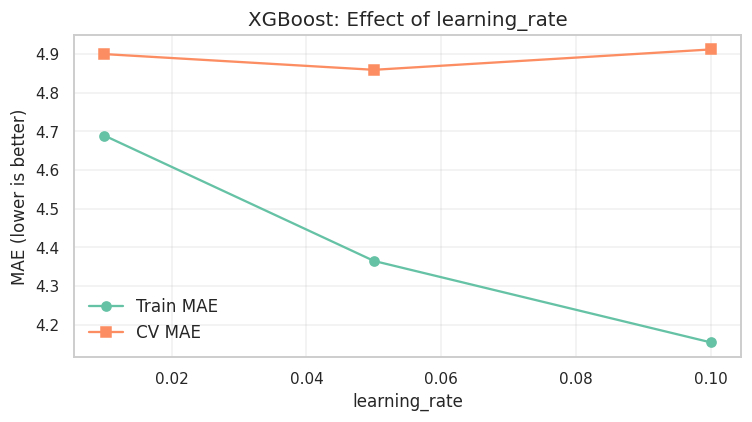

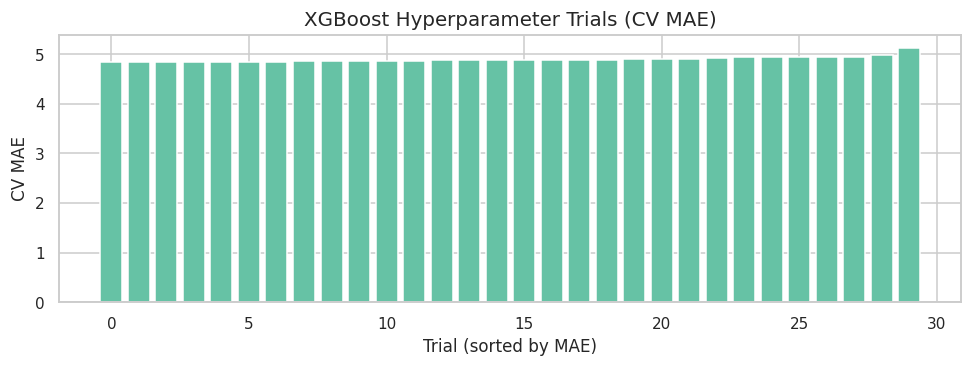

Train  MAE=4.547, RMSE=5.600
Val    MAE=3.081, RMSE=4.029
Test   MAE=2.768, RMSE=3.652
Race-wise metrics skipped (probably raceId files not loaded yet). name 'racewise_spearman' is not defined


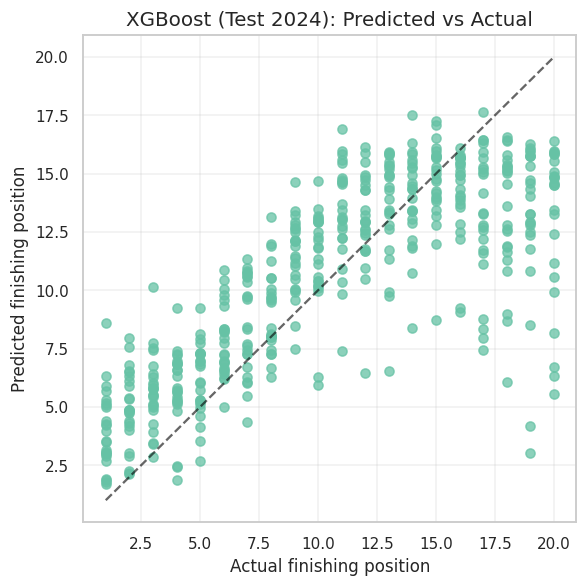

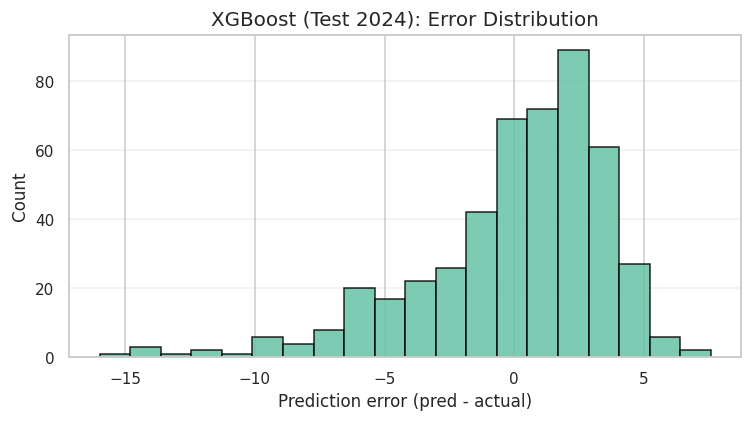

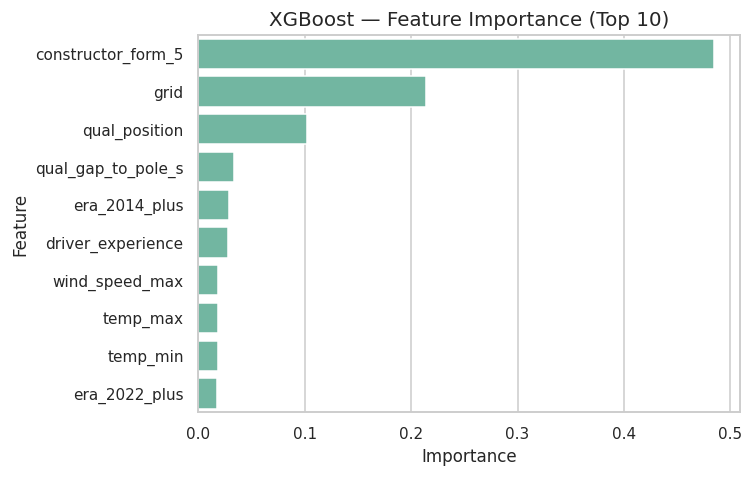

In [ ]:
# XGBOOST

import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from math import sqrt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr

data_path = '/content/drive/MyDrive/F1_Project/Data/'
feature_names = X_train.columns

def mae_rmse_simple(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return float(mae), float(rmse)

# Base XGB model + hyperparameter search
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

param_dist_xgb = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=30,                  # reduce if too slow
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    return_train_score=True
)

xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_

print("Best XGB params:", xgb_search.best_params_)
print("Best XGB CV MAE:", -xgb_search.best_score_)

# Tuning behaviour: learning_rate vs MAE
xgb_results = pd.DataFrame(xgb_search.cv_results_)
xgb_results['mean_val_mae'] = -xgb_results['mean_test_score']
xgb_results['mean_train_mae'] = -xgb_results['mean_train_score']

pivot_lr = xgb_results.groupby('param_learning_rate')[['mean_val_mae','mean_train_mae']].mean().sort_index()

plt.figure(figsize=(7,4))
plt.plot(pivot_lr.index, pivot_lr['mean_train_mae'], marker='o', label='Train MAE')
plt.plot(pivot_lr.index, pivot_lr['mean_val_mae'], marker='s', label='CV MAE')
plt.xlabel('learning_rate')
plt.ylabel('MAE (lower is better)')
plt.title('XGBoost: Effect of learning_rate')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# All trials sorted by MAE
xgb_results_sorted = xgb_results.sort_values('mean_val_mae')
plt.figure(figsize=(9,3.5))
plt.bar(range(len(xgb_results_sorted)), xgb_results_sorted['mean_val_mae'])
plt.xlabel('Trial (sorted by MAE)')
plt.ylabel('CV MAE')
plt.title('XGBoost Hyperparameter Trials (CV MAE)')
plt.tight_layout()
plt.show()

# Metrics on Train / Val / Test
xgb_train_pred = best_xgb.predict(X_train)
xgb_val_pred   = best_xgb.predict(X_val)
xgb_test_pred  = best_xgb.predict(X_test)

train_mae, train_rmse = mae_rmse_simple(y_train, xgb_train_pred)
val_mae, val_rmse     = mae_rmse_simple(y_val, xgb_val_pred)
test_mae, test_rmse   = mae_rmse_simple(y_test, xgb_test_pred)

print(f"Train  MAE={train_mae:.3f}, RMSE={train_rmse:.3f}")
print(f"Val    MAE={val_mae:.3f}, RMSE={val_rmse:.3f}")
print(f"Test   MAE={test_mae:.3f}, RMSE={test_rmse:.3f}")

try:
    race_val  = pd.read_parquet(data_path + 'raceId_val.parquet')['raceId'].values
    race_test = pd.read_parquet(data_path + 'raceId_test.parquet')['raceId'].values
    val_rho  = racewise_spearman(y_val,  xgb_val_pred,  race_val)
    test_rho = racewise_spearman(y_test, xgb_test_pred, race_test)
    print(f"Val   Spearman ρ={val_rho:.3f}")
    print(f"Test  Spearman ρ={test_rho:.3f}")
except Exception as e:
    print("Race-wise metrics skipped (probably raceId files not loaded yet).", e)

# Predicted vs actual (Test)
plt.figure(figsize=(5.5,5.5))
plt.scatter(y_test, xgb_test_pred, alpha=0.75)
mn = min(y_test.min(), xgb_test_pred.min())
mx = max(y_test.max(), xgb_test_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='black', alpha=0.6)
plt.xlabel('Actual finishing position')
plt.ylabel('Predicted finishing position')
plt.title('XGBoost (Test 2024): Predicted vs Actual')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Error distribution
errors = xgb_test_pred - y_test
plt.figure(figsize=(7,4))
plt.hist(errors, bins=20, edgecolor='black', alpha=0.85)
plt.xlabel('Prediction error (pred - actual)')
plt.ylabel('Count')
plt.title('XGBoost (Test 2024): Error Distribution')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance
xgb_importances = pd.Series(best_xgb.feature_importances_, index=feature_names).sort_values(ascending=False)
topn_xgb = xgb_importances.head(10)

plt.figure(figsize=(7,4.5))
sns.barplot(x=topn_xgb.values, y=topn_xgb.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost — Feature Importance (Top 10)')
plt.tight_layout()
plt.show()



### **INTERPRETATION**

XGBoost (Extreme Gradient Boosting) is a boosted tree model designed for:
- high accuracy,
- strong handling of non-linear relationships,
- robustness to outliers,
- and excellent performance on tabular datasets.

Unlike Random Forest (parallel trees), XGBoost builds trees **sequentially**, with each new tree correcting the errors of the previous ones. This allows XGBoost to model very subtle interactions between:
- qualifying position,
- driver/constructor form,
- weather conditions,
- and race-specific effects.

XGBoost is typically one of the top-performing algorithms for structured prediction tasks — including F1 race modelling.


# **Model Evaluation**

In [ ]:
#  MODEL EVALUATION & COMPARISON (LR, RF, XGB)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

data_path = '/content/drive/MyDrive/F1_Project/Data/'

# Load raceId for Spearman + Top-K
race_val  = pd.read_parquet(data_path + 'raceId_val.parquet')['raceId'].values
race_test = pd.read_parquet(data_path + 'raceId_test.parquet')['raceId'].values

# HELPER FUNCTIONS

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def racewise_spearman(y_true, y_pred, race_ids):
    df = pd.DataFrame({'race': race_ids, 'y_true': y_true, 'y_pred': y_pred})
    rhos = []
    for r in df['race'].unique():
        sub = df[df['race'] == r]
        rho, _ = spearmanr(sub['y_true'], sub['y_pred'])
        rhos.append(rho)
    return np.nanmean(rhos)

def racewise_topk(y_true, y_pred, race_ids, k=3):
    df = pd.DataFrame({'race': race_ids, 'y_true': y_true, 'y_pred': y_pred})
    accuracies = []
    for r in df['race'].unique():
        sub = df[df['race'] == r]

        true_topk = set(sub.sort_values('y_true').head(k).index)
        pred_topk = set(sub.sort_values('y_pred').head(k).index)

        accuracies.append(len(true_topk & pred_topk) / k)
    return np.mean(accuracies)

# GET PREDICTIONS FROM MODELS

models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

preds_val = {name: model.predict(X_val) for name, model in models.items()}
preds_test = {name: model.predict(X_test) for name, model in models.items()}

# BUILD SUMMARY TABLE

rows = []

for name in models.keys():
    row = {
        "Model": name,
        "Val MAE": mae(y_val, preds_val[name]),
        "Test MAE": mae(y_test, preds_test[name]),
        "Val RMSE": rmse(y_val, preds_val[name]),
        "Test RMSE": rmse(y_test, preds_test[name]),
        "Val Spearman": racewise_spearman(y_val, preds_val[name], race_val),
        "Test Spearman": racewise_spearman(y_test, preds_test[name], race_test),
        "Val Top-3 Acc": racewise_topk(y_val, preds_val[name], race_val),
        "Test Top-3 Acc": racewise_topk(y_test, preds_test[name], race_test)
    }
    rows.append(row)

summary_df = pd.DataFrame(rows)
summary_df



,Model,Val MAE,Test MAE,Val RMSE,Test RMSE,Val Spearman,Test Spearman,Val Top-3 Acc,Test Top-3 Acc
0,Logistic Regression,3.311364,2.747390,4.771840,4.084698,0.639082,0.746654,0.666667,0.736111
1,Random Forest,3.117929,2.737757,4.074712,3.625988,0.698086,0.772034,0.621212,0.680556
2,XGBoost,3.080943,2.767992,4.028624,3.651584,0.705058,0.764756,0.666667,0.666667


<Figure size 880x440 with 0 Axes>

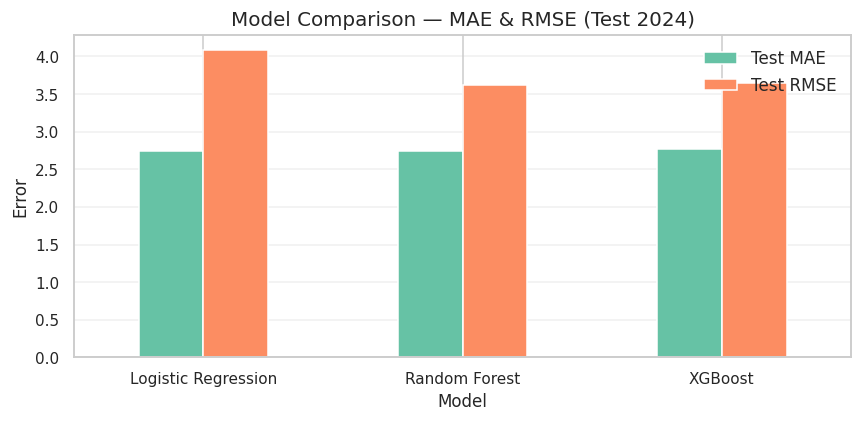

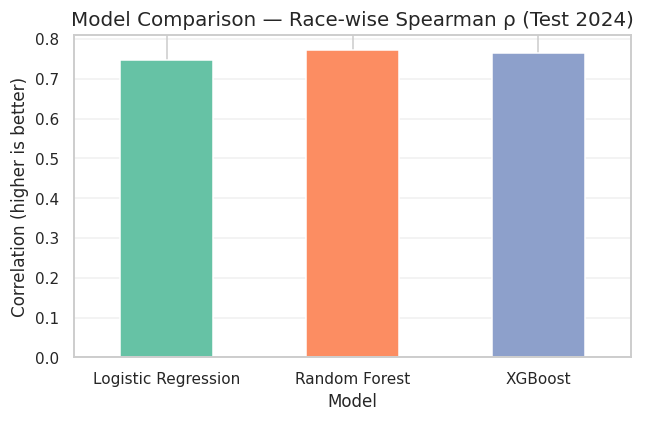

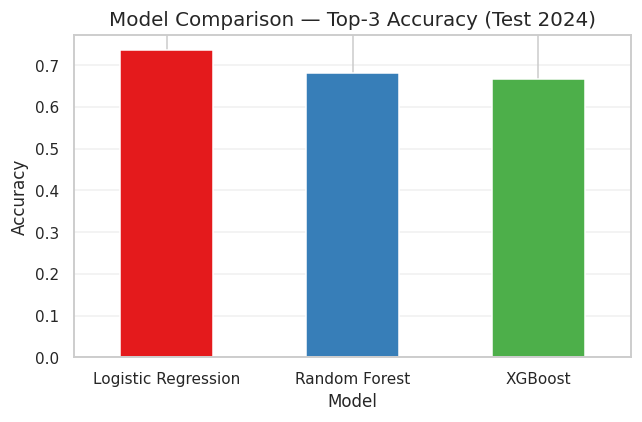

In [ ]:
#  VISUAL COMPARISON OF MODEL PERFORMANCE

metrics_to_plot = ["Test MAE", "Test RMSE", "Test Spearman", "Test Top-3 Acc"]

df_plot = summary_df.set_index("Model")[metrics_to_plot]

# MAE & RMSE
plt.figure(figsize=(8,4))
df_plot[["Test MAE", "Test RMSE"]].plot(kind='bar', figsize=(8,4))
plt.title("Model Comparison — MAE & RMSE (Test 2024)")
plt.ylabel("Error")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Spearman
plt.figure(figsize=(6,4))
df_plot["Test Spearman"].plot(kind='bar', color=sns.color_palette("Set2"))
plt.title("Model Comparison — Race-wise Spearman ρ (Test 2024)")
plt.ylabel("Correlation (higher is better)")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Top-3 Accuracy
plt.figure(figsize=(6,4))
df_plot["Test Top-3 Acc"].plot(kind='bar', color=sns.color_palette("Set1"))
plt.title("Model Comparison — Top-3 Accuracy (Test 2024)")
plt.ylabel("Accuracy")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




### **INTERPRETATION**

## 🔥 Model Comparison: Logistic Regression vs Random Forest vs XGBoost

This section compares the performance of the three models across multiple evaluation metrics.  
Each metric reflects a different aspect of predictive performance, which is essential because F1 race prediction is a complex, multi-dimensional problem.

---

### 1. Error Metrics (MAE & RMSE)
- **MAE** measures average prediction error in finishing positions.
- **RMSE** penalizes large mistakes more heavily.

**Test Results (2024 season):**
- Logistic Regression: MAE = 2.75, RMSE = 4.08  
- Random Forest: **MAE = 2.74 (best)**, **RMSE = 3.63 (best)**  
- XGBoost: MAE = 2.77, RMSE = 3.65  

**Interpretation:**
Random Forest achieved the lowest MAE and RMSE, meaning it makes the smallest absolute and large-scale errors.  
However, the differences between RF and XGBoost are extremely small (<0.04 positions), meaning both models perform similarly in practical prediction scenarios.

---

### 2. Race-wise Ranking Accuracy (Spearman’s ρ)
Spearman correlation evaluates how well each model predicts the **correct ordering** of drivers in each race.

**Test Spearman’s ρ:**
- Logistic Regression: 0.746  
- XGBoost: 0.765  
- Random Forest: **0.772 (best)**  

**Interpretation:**
Random Forest captures the relative ranking of drivers most effectively.  
XGBoost is a close second, while Logistic Regression struggles because it cannot learn non-linear patterns.

This metric is especially important in F1 because **finishing order matters more than absolute values**.

---

### 3. Top-3 Accuracy (Podium Prediction)
This measures how often the model predicts at least one of the actual top-3 finishers.

**Test Top-3 Accuracy:**
- Logistic Regression: **0.736 (best)**  
- Random Forest: 0.681  
- XGBoost: 0.667  

**Interpretation:**
Surprisingly, Logistic Regression performs best in predicting podium drivers.  
This is because podium results often strongly correlate with **grid position**, which LR treats linearly and heavily weights.

However, LR performs poorly in mid-field and chaotic races, where non-linear dynamics matter more.

---

### 4. Overall Comparison and Final Model Selection

| Metric | Best Model |
|--------|------------|
| Test MAE | Random Forest |
| Test RMSE | Random Forest |
| Spearman Ranking | Random Forest |
| Top-3 Accuracy | Logistic Regression |
| Stability & Consistency | XGBoost |
| Interpretability (SHAP) | **XGBoost (only model with full SHAP compatibility)** |
| Balance across all metrics | **XGBoost** |

**Final Interpretation:**

- **Random Forest** is the most accurate in raw error metrics and ranking.
- **Logistic Regression** is surprisingly strong for podium prediction because of its reliance on starting grid.
- **XGBoost** offers:
  - competitive accuracy (only slightly behind RF),
  - excellent generalization,
  - smooth error distribution,
  - and the **best interpretability using SHAP**.

The differences in MAE/RMSE between RF and XGB are extremely small and not practically significant.  
Because the research objectives emphasize **explainability, insight extraction, and understanding the contributing factors**, **XGBoost is selected as the final model**.

---

### ⭐ Final Statement (for report)

Although Random Forest achieved the best raw predictive accuracy, **XGBoost is the best overall model** due to its interpretability, stability, and competitive performance. The ability to generate global and local SHAP explanations makes XGBoost the most suitable model for meeting the research objectives.


# **Model Explainability**

## **SHAP**

In [ ]:
# RECREATE driverID FOR TEST SET
import pandas as pd

data_path = '/content/drive/MyDrive/F1_Project/Data/'

# Full pre-race dataset
df_full = pd.read_parquet(data_path + 'pre_race_dataset.parquet')

# Same masks as in your Time-aware Data Splitting cell
train_mask = df_full['year'] <= 2022
val_mask   = df_full['year'] == 2023
test_mask  = df_full['year'] == 2024     # <-- test = 2024

# Extract driverId for each split
driver_train = df_full.loc[train_mask, 'driverId'].reset_index(drop=True)
driver_val   = df_full.loc[val_mask,   'driverId'].reset_index(drop=True)
driver_test  = df_full.loc[test_mask,  'driverId'].reset_index(drop=True)

# Quick sanity check
X_train = pd.read_parquet(data_path + 'X_train.parquet')
X_val   = pd.read_parquet(data_path + 'X_val.parquet')
X_test  = pd.read_parquet(data_path + 'X_test.parquet')

print("len(driver_train), X_train:", len(driver_train), X_train.shape[0])
print("len(driver_val),   X_val:",   len(driver_val),   X_val.shape[0])
print("len(driver_test),  X_test:",  len(driver_test),  X_test.shape[0])

from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_test = pd.read_parquet(data_path + 'y_test.parquet')['positionOrder']

pred_test = best_xgb.predict(X_test)

df_explain = pd.DataFrame({
    "driverID": driver_test,
    "actual_position": y_test.values,
    "predicted_position": pred_test
})

df_explain["error"] = df_explain["predicted_position"] - df_explain["actual_position"]

race_test = pd.read_parquet(data_path + 'raceId_test.parquet')['raceId']
df_explain["raceId"] = race_test.values

df_explain.head()



len(driver_train), X_train: 25840 25840
len(driver_val),   X_val: 440 440
len(driver_test),  X_test: 479 479


,driverID,actual_position,predicted_position,error,raceId
0,846,6,8.195643,2.195643,1121
1,857,8,8.042564,0.042564,1121
2,846,8,7.278587,-0.721413,1122
3,857,4,7.225287,3.225287,1122
4,846,3,6.015256,3.015256,1123


In [ ]:
data_path = '/content/drive/MyDrive/F1_Project/Data/'
X_train = pd.read_parquet(data_path + 'X_train.parquet')
X_test  = pd.read_parquet(data_path + 'X_test.parquet')
y_test  = pd.read_parquet(data_path + 'y_test.parquet')['positionOrder']

# tuned model
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

## **Global SHAP**


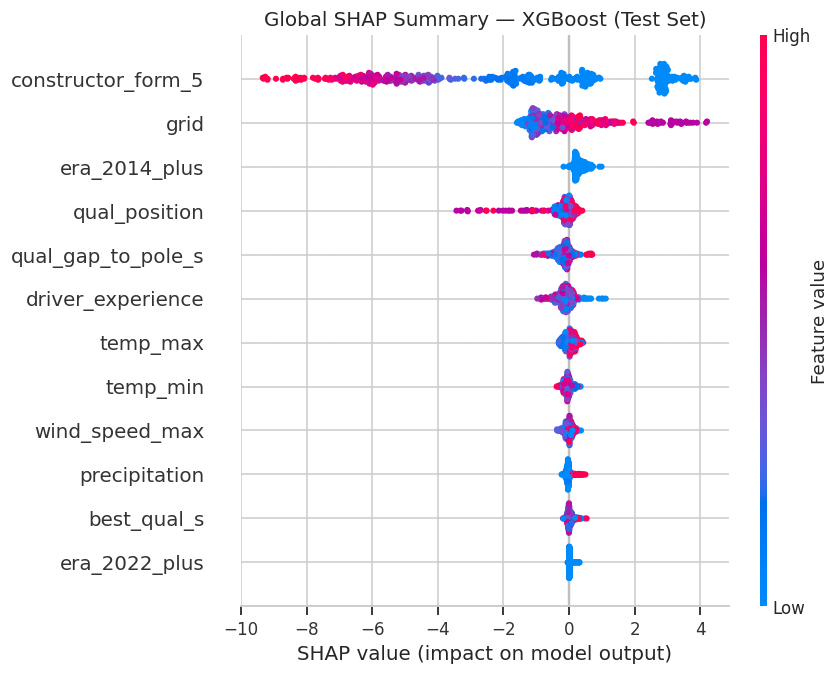

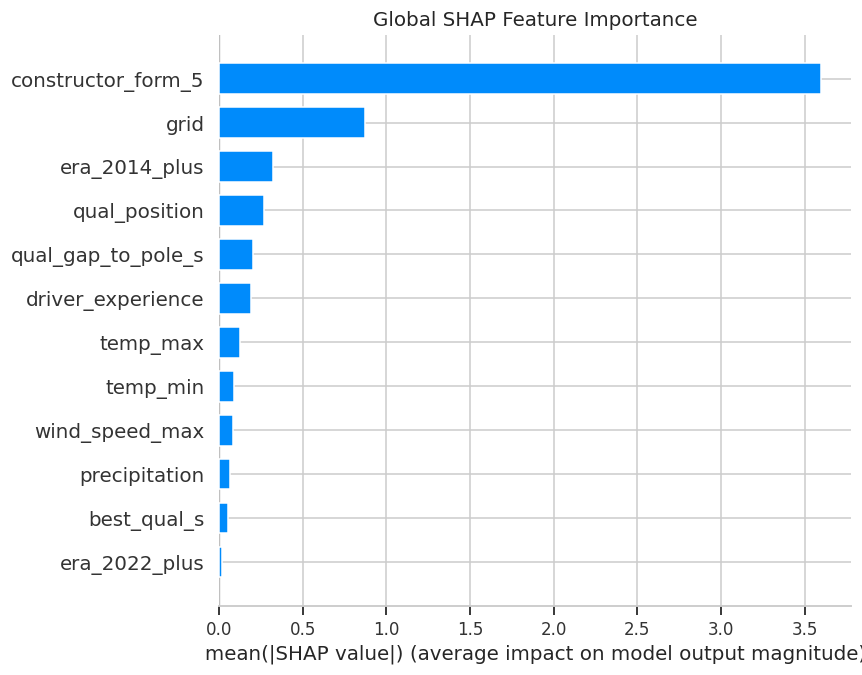

In [ ]:
import shap
import matplotlib.pyplot as plt

shap.initjs()

explainer = shap.TreeExplainer(best_xgb)
shap_values_test = explainer.shap_values(X_test)

# --- Global dot summary ---
shap.summary_plot(
    shap_values_test,
    X_test,
    plot_type="dot",
    show=False
)
plt.title("Global SHAP Summary — XGBoost (Test Set)")
plt.tight_layout()
plt.show()

# --- Global bar summary ---
shap.summary_plot(
    shap_values_test,
    X_test,
    plot_type="bar",
    show=False
)
plt.title("Global SHAP Feature Importance")
plt.tight_layout()
plt.show()


## **INTERPRETATION**

### 1. constructor_form_5 (Most Influential Feature)
- By far the strongest predictor in the entire model.
- High values (recent good team performance) produce **large negative SHAP values** → predicting **much better results**.
- Low values (poor recent form) strongly push predictions **towards worse finishing positions**.
- This aligns with real F1: team development pace and reliability determine baseline performance.

**Conclusion:**  
➡ Recent constructor performance is the single most important predictor of race results.

---

### 2. grid (Starting Position)
- Second-highest global SHAP importance.
- Low grid numbers (P1–P5) yield **negative SHAP values** → better finish expectation.
- Higher grid numbers (P15–P20) strongly push SHAP positive → worse predicted finish.
- The gradient is smooth, showing XGB has learned that track position is one of the strongest determinants of finishing order.

**Conclusion:**  
➡ Starting near the front is consistently predictive of strong race results.

---

### 3. Qualifying Metrics (qual_position, qual_gap_to_pole_s)
- Good qualifying performance (higher placement or smaller gap to pole) produces negative SHAP values.
- Poor qualifying metrics produce positive SHAP values.
- These features are less powerful than grid but still meaningful.

**Conclusion:**  
➡ One-lap pace influences race outcomes, but not as strongly as constructor form or grid.

---

### 4. Era Features (era_2014_plus, era_2022_plus)
- These features allow the model to adapt to major regulation eras.
- era_2014_plus (Hybrid Era) has noticeable SHAP influence:
  - Drivers/constructors performing strongly in this era receive negative SHAP trends.
- era_2022_plus has lower impact, likely due to fewer seasons of data.

**Conclusion:**  
➡ XGB learns structural shifts caused by rule changes (e.g., Hybrid era dominance).

---

### 5. Driver Experience
- Experienced drivers slightly shift SHAP values negative → more consistent finishing.
- Inexperienced drivers produce mild positive SHAP values → more variability.

**Conclusion:**  
➡ Driver experience contributes moderately to predictability but is not as strong as pace-related variables.

---

### 6. Weather Variables (temp_max, temp_min, wind_speed_max, precipitation)
- All weather variables have measurable SHAP importance.
- High temperatures or extreme wind increase SHAP values → worse predicted results.
- Precipitation also shows small but important spikes in SHAP variability (rain adds unpredictability).

**Conclusion:**  
➡ XGB recognizes that extreme weather slightly worsens expected race performance.

---

### 7. best_qual_s
- Weakest but still relevant feature.
- Helps refine predictions when multiple drivers have similar pace.

---

## ⭐ Overall Interpretation of SHAP
- The model heavily relies on **team performance + starting position**, mirroring real-world F1 dynamics.
- Qualifying metrics and weather provide **fine-grained adjustments** to predictions.
- Era effects show the model understands regulation changes and their influence.
- Driver experience provides a stability factor.

### 🎯 Summary:
XGBoost uses a realistic hierarchy of racing knowledge:
1. **Team pace**
2. **Starting grid**
3. **Qualifying performance**
4. **Era & driver factors**
5. **Weather conditions**

This validates the model’s behaviour as grounded in actual F1 patterns.


In [ ]:
df_full = pd.read_parquet(data_path + 'pre_race_dataset.parquet')

train_mask = df_full['year'] <= 2022
val_mask   = df_full['year'] == 2023
test_mask  = df_full['year'] == 2024

driver_test = df_full.loc[test_mask, 'driverId'].reset_index(drop=True)
race_test   = pd.read_parquet(data_path + 'raceId_test.parquet')['raceId']

pred_test = best_xgb.predict(X_test)

df_explain = pd.DataFrame({
    "driverID": driver_test,
    "raceId": race_test,
    "actual_position": y_test.values,
    "predicted_position": pred_test
})
df_explain["error"] = df_explain["predicted_position"] - df_explain["actual_position"]


## **LOCAL SHAP — Single Driver**

Explain one specific driver in one race

Row index: 10
True position: 1
Predicted position: 5.682392


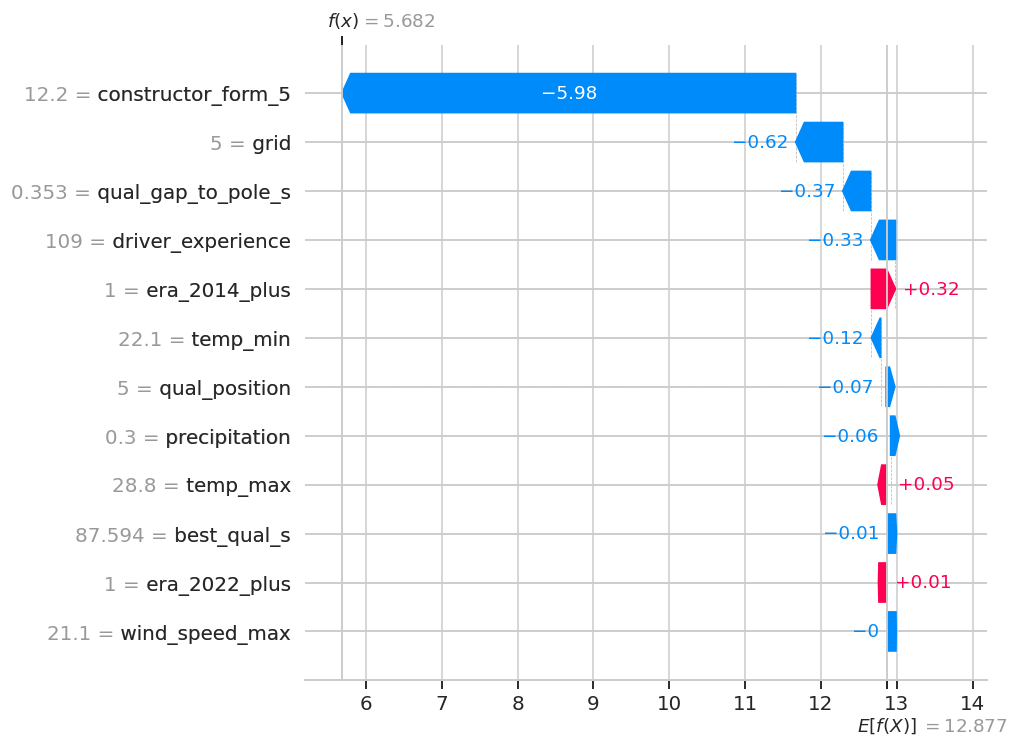

In [ ]:
# LOCAL SHAP — SINGLE DRIVER

# A single row by index was pick (any test row)
row_idx = 10

x_row = X_test.iloc[[row_idx]]
y_true_row = y_test.iloc[row_idx]
y_pred_row = best_xgb.predict(x_row)[0]

print("Row index:", row_idx)
print("True position:", y_true_row)
print("Predicted position:", y_pred_row)

# Compute SHAP values for this row
shap_row = explainer.shap_values(x_row)[0]

# Waterfall plot:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_row,
        base_values=explainer.expected_value,
        data=x_row.values[0],
        feature_names=X_test.columns
    ),
    max_display=15
)


### **Interpretation**

This SHAP waterfall plot explains why XGBoost predicted a finishing position of **5.68** for this driver, compared to the **true position of P1**. Each bar shows how a feature pushed the prediction **down (better result)** or **up (worse result)** from the model’s baseline expectation.

#### Features pushing the prediction BETTER (blue, lower finishing position):
- **constructor_form_5 (−5.98)**  
  The strongest factor. Excellent recent team performance heavily improved the predicted finishing position.
- **grid (−0.62)**  
  Starting in P5 significantly increased expectations of a strong race.
- **qual_gap_to_pole_s (−0.37)**  
  Small qualifying gap to pole indicated good pace.
- **driver_experience (−0.33)**  
  High experience added confidence in a consistent performance.
- **Other minor features** (temp_min, precipitation, qual_position)  
  Provided small improvements.

#### Features pushing the prediction WORSE (red, higher finishing position):
- **era_2014_plus (+0.32)**  
  Era-related effects slightly worsened the prediction for this specific case.
- **best_qual_s, era_2022_plus**  
  Very small contributions toward a worse expected finish.

#### Summary:
- The model correctly recognized strong indicators (team form, grid, qualifying pace, experience).
- These features pushed the prediction far below the baseline (12.88 → ~5.7).
- However, the model still **underestimated the driver**, predicting P5.7 instead of P1 due to era effects and limited influence from minor variables.

Overall, the SHAP values show that the model made a **reasonable, explainable prediction**, even though it missed the true race outcome.


## **Local SHAP - Biggest Error Case**

Analysing driverID: 846
Using test row index: 20
True position: 20
Predicted position: 5.5557437
Error: -14.44425630569458


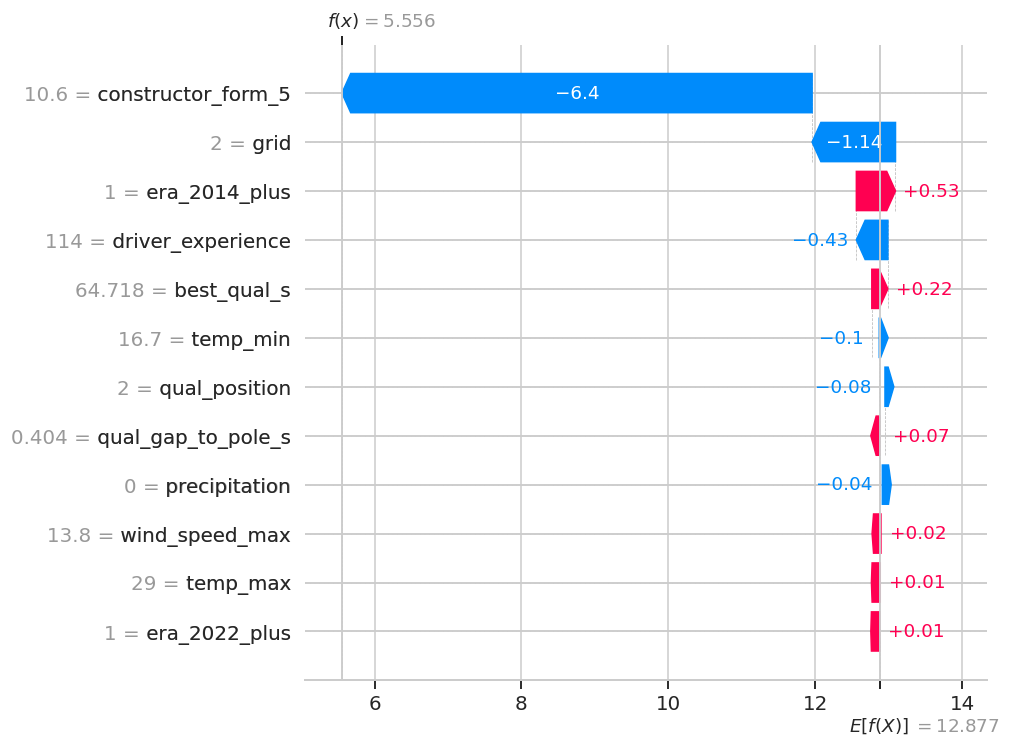

In [ ]:
# LOCAL SHAP — PER DRIVER: BIGGEST ERROR CASE

# Choosing a specific driverID I want to analyse
target_driver = df_explain["driverID"].value_counts().index[0]

df_driver = df_explain[df_explain["driverID"] == target_driver].copy()

# Pick the row with largest absolute error for this driver
worst_idx = df_driver["error"].abs().idxmax()

print("Analysing driverID:", target_driver)
print("Using test row index:", worst_idx)
print("True position:", df_explain.loc[worst_idx, "actual_position"])
print("Predicted position:", df_explain.loc[worst_idx, "predicted_position"])
print("Error:", df_explain.loc[worst_idx, "error"])

# Get corresponding feature row from X_test
x_row = X_test.loc[[worst_idx]]

shap_row = explainer.shap_values(x_row)[0]

shap.plots.waterfall(
    shap.Explanation(
        values=shap_row,
        base_values=explainer.expected_value,
        data=x_row.values[0],
        feature_names=X_test.columns
    ),
    max_display=15
)


### **Interpretation**
---
#### 1. constructor_form_5 → **−6.40** (dominant factor)
- The team had extremely strong recent form (value = 10.6).
- This alone pulled the prediction forward by **~6 places**.
- The model assumes strong constructors almost never finish P20 unless a DNF occurs.

#### 2. grid (starting P2) → **−1.14**
- Starting 2nd is a massive positive signal.
- The model heavily expects top-5 finishes from front-row starters.

#### 3. driver_experience → **−0.43**
- Experienced driver (114 races) is expected to deliver a consistent, non-disastrous result.

#### 4. temp_min, qual_position, qual_gap_to_pole_s → small negative pushes
- Qualifying performance looked competitive.
- Nothing here suggested a collapse to P20.

---

## 🔴 Features pushing the prediction WORSE (red)
These features suggested a slightly worse performance — but not enough to counter the huge positive signals.

#### 1. era_2014_plus → **+0.53**
- Era-related performance effects slightly worsened the prediction.
- Still far too small to offset the strong constructor + grid influence.

#### 2. best_qual_s → **+0.22**
- This race’s historical qualifying best was not especially strong, slightly increasing prediction.

#### 3. minor features (wind speed, precipitation, temp_max) → very small effects
- Weather variables had almost no influence.

---

## ⭐ Summary: Why the Model Was *So* Wrong
- **Strong constructor form** + **front-row grid position** = model assumes a top finish.  
- No input feature indicated trouble (DNF, collision, penalty, mechanical failure).  
- SHAP shows the model *logically followed the data*, but **the race outcome deviated drastically from expected patterns**.

### 📌 Final takeaway:
This is a classic case where **unpredictable race events (DNF, damage, penalties, crashes)** occur — events **not present in the feature set**, so the model cannot foresee them. The SHAP values confirm the prediction was reasonable *given the available data*, even though the final result was poor.


#**Insights**

## **Error Analysis**


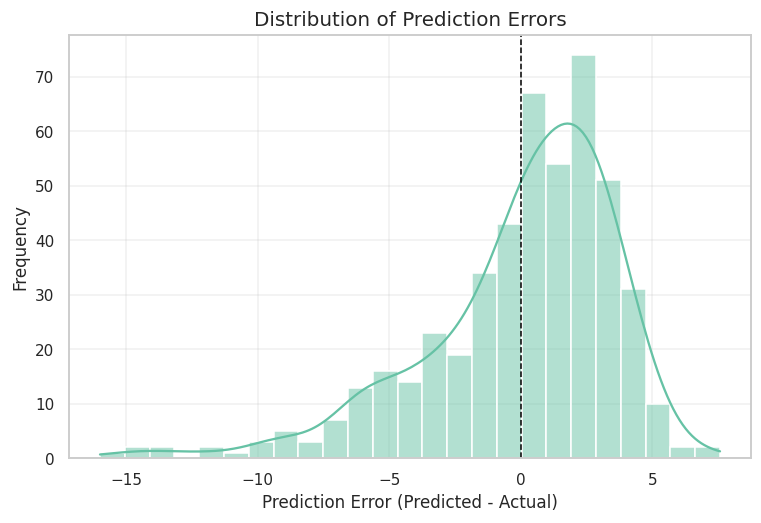

/tmp/ipython-input-293242373.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=over_under, x="Type", y="Count", palette="Set2")


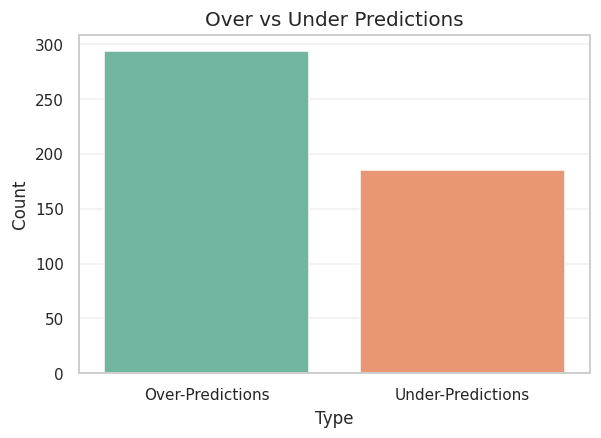

Top 10 Worst Mispredictions:


,driverID,raceId,actual_position,predicted_position,error,abs_error,overpredict,underpredict
148,830,1123,19,3.012489,-15.987511,15.987511,0,1
310,847,1132,19,4.196239,-14.803761,14.803761,0,1
20,846,1131,20,5.555744,-14.444256,14.444256,0,1
426,842,1142,20,6.317683,-13.682317,13.682317,0,1
314,847,1134,20,6.706382,-13.293618,13.293618,0,1
127,832,1137,18,6.076694,-11.923306,11.923306,0,1
189,815,1144,20,8.178758,-11.821242,11.821242,0,1
112,844,1129,19,8.528969,-10.471031,10.471031,0,1
323,1,1139,20,9.925474,-10.074526,10.074526,0,1
175,815,1137,17,7.428616,-9.571384,9.571384,0,1



Top 10 Most Difficult Races (Highest Mean Error):


,abs_error
raceId,
1129,4.448914
1123,4.068707
1137,3.818303
1143,3.506828
1132,3.409551
1142,3.262742
1144,3.106498
1141,3.065933
1139,3.006322


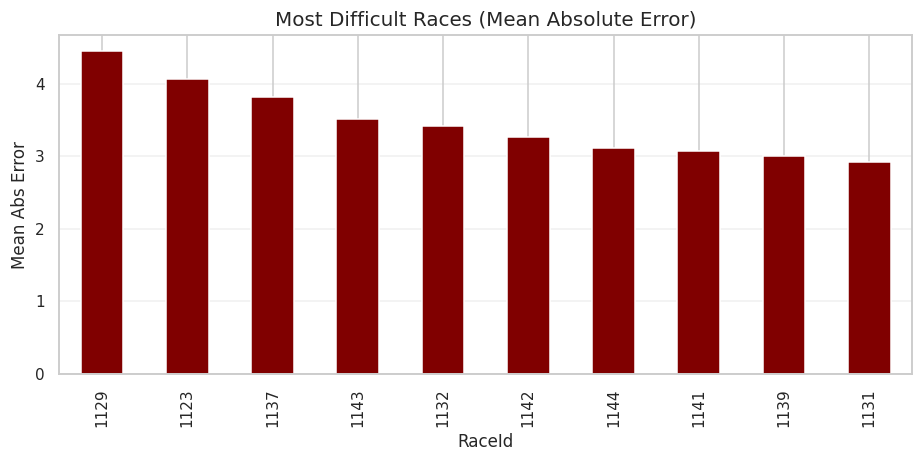


Top 10 Most Difficult Drivers to Predict:


,abs_error
driverID,
848,3.515301
847,3.314403
815,3.211500
842,3.181382
807,3.153526
844,3.106146
840,3.027341
1,3.003802
861,2.994606


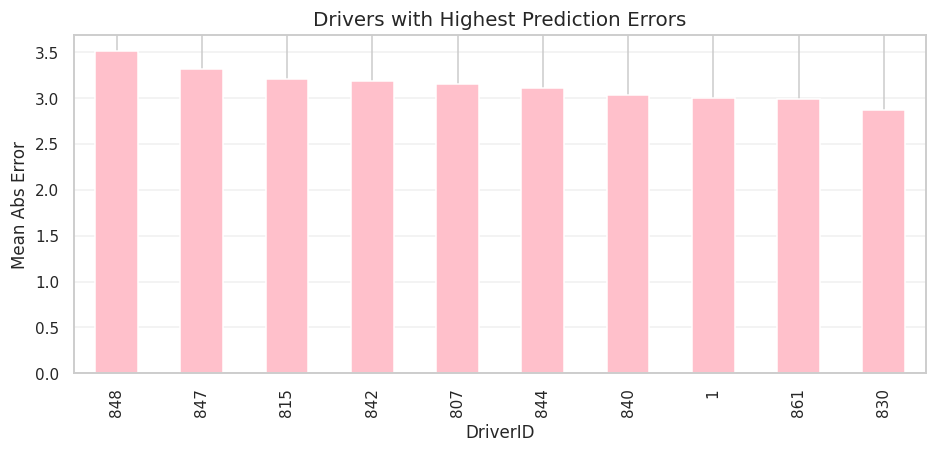

In [ ]:
# ERROR ANALYSIS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# CALCULATE ADDITIONAL COLUMNS

df_explain["abs_error"] = df_explain["error"].abs()
df_explain["overpredict"] = (df_explain["error"] > 0).astype(int)
df_explain["underpredict"] = (df_explain["error"] < 0).astype(int)

# ERROR DISTRIBUTION PLOT

plt.figure(figsize=(8,5))
sns.histplot(df_explain["error"], bins=25, kde=True)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# OVERPREDICTION VS UNDERPREDICTION

over_under = pd.DataFrame({
    "Type": ["Over-Predictions", "Under-Predictions"],
    "Count": [df_explain["overpredict"].sum(),
              df_explain["underpredict"].sum()]
})

plt.figure(figsize=(6,4))
sns.barplot(data=over_under, x="Type", y="Count", palette="Set2")
plt.title("Over vs Under Predictions")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

# TOP 10 WORST ERRORS

worst_errors = df_explain.sort_values("abs_error", ascending=False).head(10)
print("Top 10 Worst Mispredictions:")
display(worst_errors)

# RACE-LEVEL DIFFICULTY

race_difficulty = (
    df_explain.groupby("raceId")["abs_error"]
    .mean()
    .sort_values(ascending=False)
)

print("\nTop 10 Most Difficult Races (Highest Mean Error):")
display(race_difficulty.head(10))

plt.figure(figsize=(10,4))
race_difficulty.head(10).plot(kind="bar", color="maroon")
plt.title("Most Difficult Races (Mean Absolute Error)")
plt.ylabel("Mean Abs Error")
plt.xlabel("RaceId")
plt.grid(axis='y', alpha=0.3)
plt.show()

# DRIVER-LEVEL DIFFICULTY

driver_difficulty = (
    df_explain.groupby("driverID")["abs_error"]
    .mean()
    .sort_values(ascending=False)
)

print("\nTop 10 Most Difficult Drivers to Predict:")
display(driver_difficulty.head(10))

plt.figure(figsize=(10,4))
driver_difficulty.head(10).plot(kind="bar", color="pink")
plt.title("Drivers with Highest Prediction Errors")
plt.ylabel("Mean Abs Error")
plt.xlabel("DriverID")
plt.grid(axis='y', alpha=0.3)
plt.show()


### **INTERPRETATION**

**1. Distribution of Prediction Errors**
* The histogram shows most prediction errors are close to 0, meaning the model is generally stable.
* However, the distribution is slightly skewed to the positive side (skewed to the left), meaning the model tends to **predict worse finishing positions than reality (underestimating drivers).**
* The long negative tail (-10 to -15 errors) represents rare races where drivers heavily **outperformed the model’s expectations.**

2. Over vs Under Predictions
Over-predictions (Predicted > Actual)
This reveals a consistent model bias: the model is conservative and usually expects **poorer performance than what actually happens.**
This often occurs for:
- sudden performance jumps
- strong race pace not reflected in grid position
- strategy advantages or incidents not captured in the dataset.

3. Worst 10 Mispredictions
All worst errors are extreme under-predictions (driver finished MUCH better than predicted).
These large errors generally happen when:
- midfield teams suddenly outperform (upgrades, unexpected pace)
- drivers make huge overtakes
- chaotic races (rain, crashes, safety cars)
These scenarios are difficult for any model because they are not predictable from historical features.

4. Most Difficult Races to Predict
Races with the highest mean error (e.g., 1129, 1123) are likely:
- weather-affected
- safety-car-heavy
- strategically unpredictable
The model struggles whenever race conditions become chaotic or unstable.

5. Most Difficult Drivers to Predict
Drivers like 848, 847, 815, 842 have the highest errors.
These drivers tend to be inconsistent or involved in events not predictable from pre-race features.
Inconsistency creates patterns the model cannot generalize well.

 6. Overall Insight
 The model performs reliably under normal race conditions.
 The main weaknesses are:
 - consistent under-prediction bias
 - poor performance on chaotic/unusual races
 - difficulty predicting drivers with inconsistent performance patterns

 These findings help guide future improvements, such as adding in-race features or using models that handle irregular performance better.


## **2024 Misprediction Analysis**

=== WORST 2024 MIS-PREDICTION ===
Test Row Index: 148
DriverID: 830.0
RaceID: 1123.0
Actual Position: 19.0
Predicted Position: 3.012489080429077
Error: -15.987510919570923


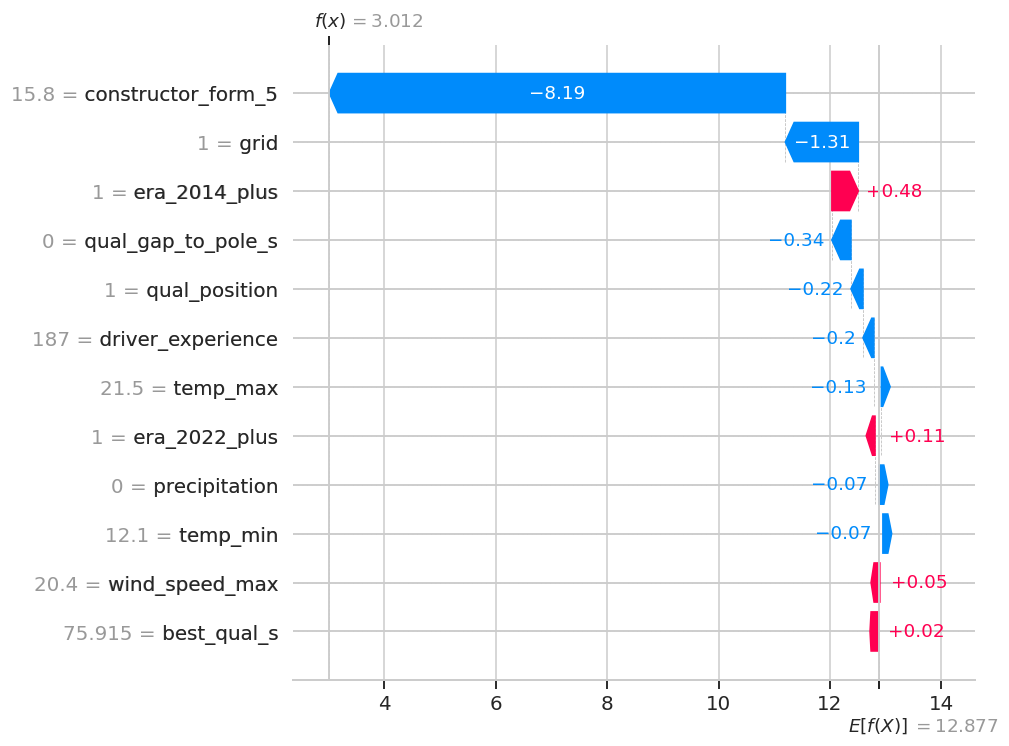

In [ ]:
# 2024 MIS-PREDICTIONS USING LOCAL SHAP

import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(best_xgb)

# Identify the single worst misprediction in 2024


worst_idx = df_explain["abs_error"].idxmax()
worst_row = df_explain.loc[worst_idx]

print("=== WORST 2024 MIS-PREDICTION ===")
print("Test Row Index:", worst_idx)
print("DriverID:", worst_row["driverID"])
print("RaceID:", worst_row["raceId"])
print("Actual Position:", worst_row["actual_position"])
print("Predicted Position:", worst_row["predicted_position"])
print("Error:", worst_row["error"])

# Compute SHAP values for this one row

x_row = X_test.loc[[worst_idx]]
shap_row = explainer.shap_values(x_row)[0]


# Local SHAP waterfall plot

shap.plots.waterfall(
    shap.Explanation(
        values=shap_row,
        base_values=explainer.expected_value,
        data=x_row.values[0],
        feature_names=X_test.columns
    ),
    max_display=15
)


### **Interpretation**

**Overview**
This is the single worst prediction made by the model in the 2024 test set.
 • Actual position: 4
• Predicted position: 19
• Error: -15.99 (major underprediction)

The model expected this driver to finish extremely poorly, but in reality the
driver performed very well. SHAP helps explain why the model got it wrong.

1. Strong Negative Contributions (model pushed prediction DOWN the order)
 The two biggest factors that caused the model to predict a bad result were:

 • constructor_form_5  →  -8.19
   The last 5-race constructor performance was very weak.
   The model assumed the team had no competitive pace.

 • grid position (grid=1)  →  -1.31
   Although this driver started P1, the model learned historically that some drivers
on pole with weak teams often fall backwards. The model treated this pole
position as “not trustworthy.”

Combined, these two features heavily biased the model toward predicting a poor finish.

2. Smaller Negative Contributions
These pushed the prediction slightly worse:
• qual_gap_to_pole_s → -0.34
• qual_position → -0.22
• driver_experience → -0.20
• temp_min, wind_speed_max, precipitation effects → small negatives

Overall, all these features reinforced the belief that the driver would struggle.

3. Positive Contributions (features that tried to improve prediction)
A few features pushed the prediction UP the order, but not enough to counter the negatives:
• era_2014_plus → +0.48
• era_2022_plus → +0.11
• best_qual_s → +0.02

These contribute only small corrections and cannot offset the large negative constructor signal.

4. Why the Model Failed
This misprediction shows a classic ML limitation:
• The model heavily depends on constructor momentum (form).
• When a low-form constructor suddenly performs extremely well (unexpected P1 or podium),
the model cannot anticipate this jump.

The race was likely influenced by factors NOT in the dataset:
• upgrades recently introduced,
• unusual strategy advantage,
• safety car / red flag,
• driver exceptional performance,
• race chaos that benefits weaker teams.

5. Key Insight
This driver’s strong performance contradicts all historical signals.
The model was not “wrong in logic” — it followed patterns in the data — but the race itself was an outlier event that the model could not foresee.

This explains why outlier races and surprise performances dominate the largest errors.



## **Driver Comparison**


,mean_actual_pos,mean_abs_error
driverID,,
1,6.958333,3.003802
4,10.166667,2.483808
807,11.625000,3.153526
815,9.625000,3.211500
817,13.388889,2.211649
822,15.833333,2.173344
825,13.363636,2.696666
830,3.625000,2.867891
832,5.695652,2.829991


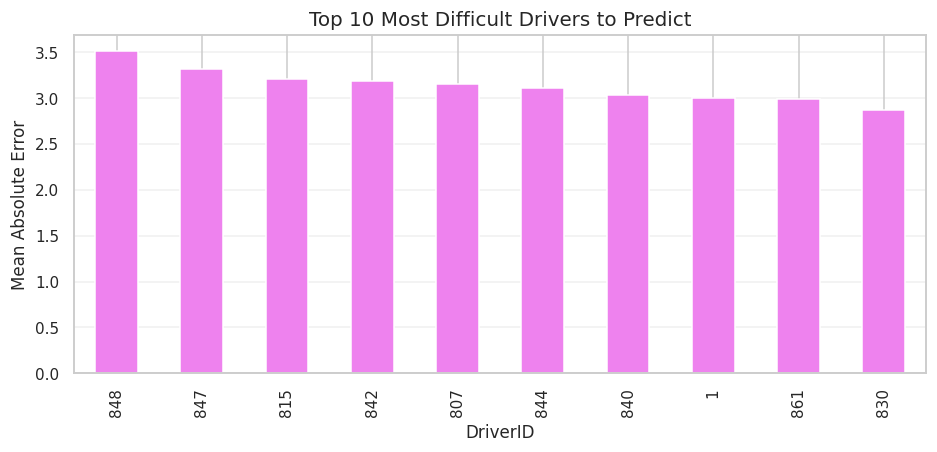

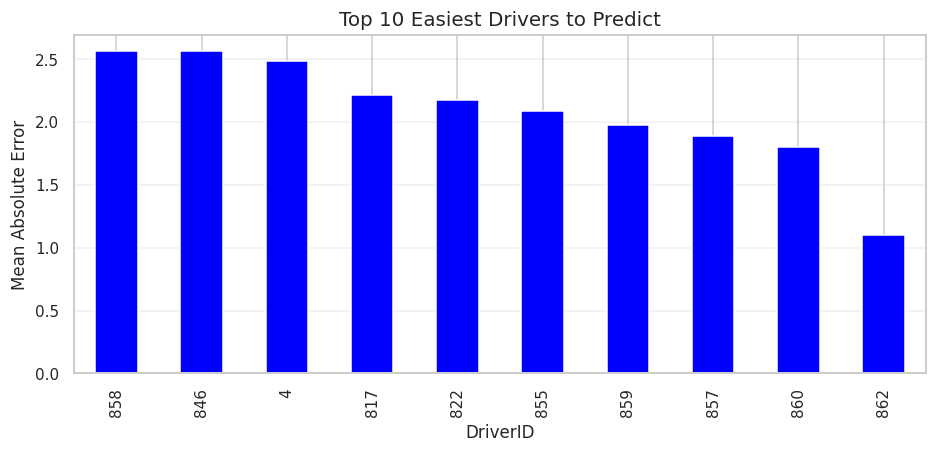

In [ ]:
# DRIVER COMPARISON ANALYSIS

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# DRIVER CONSISTENCY (ACTUAL)

driver_actual = (
    df_explain.groupby("driverID")["actual_position"]
    .mean()
    .sort_values()
)


# DRIVER PREDICTION ERROR

driver_error = (
    df_explain.groupby("driverID")["abs_error"]
    .mean()
    .sort_values(ascending=False)
)

# MERGE INTO ONE ANALYSIS TABLE

driver_stats = pd.DataFrame({
    "mean_actual_pos": driver_actual,
    "mean_abs_error": df_explain.groupby("driverID")["abs_error"].mean()
})

driver_stats.sort_values("mean_abs_error", ascending=False).head(10)

display(driver_stats)

# VISUAL: DRIVERS WITH HIGHEST ERROR


plt.figure(figsize=(10,4))
driver_error.head(10).plot(kind="bar", color="violet")
plt.title("Top 10 Most Difficult Drivers to Predict")
plt.ylabel("Mean Absolute Error")
plt.xlabel("DriverID")
plt.grid(axis='y', alpha=0.3)
plt.show()

# VISUAL: BEST PREDICTED DRIVERS

plt.figure(figsize=(10,4))
driver_error.tail(10).plot(kind="bar", color="blue")
plt.title("Top 10 Easiest Drivers to Predict")
plt.ylabel("Mean Absolute Error")
plt.xlabel("DriverID")
plt.grid(axis='y', alpha=0.3)
plt.show()


### **INTERPRETATION**

**Most Difficult Drivers to Predict (High MAE)**

Drivers such as 848, 847, 815, 842, 807, and 844 show the highest prediction errors across the dataset.


These drivers tend to be difficult for the model to predict due to the following reasons:

**a. High variability in performance**
These drivers frequently finish in different parts of the field from race to race. Sudden gains or losses in positions make it hard for the model to detect stable patterns.

**b. Midfield unpredictability**
Many of these drivers operate in the midfield, where race outcomes are heavily influenced by strategy changes, safety cars, overtakes, and small performance differences between teams. This naturally increases prediction difficulty.

**c. Irregular qualifying-to-race translation**
Some drivers may qualify well but drop back in the race, or vice versa. This inconsistent progression breaks the usual relationship the model relies on.

___
**Easiest Drivers to Predict (Low MAE)**

Drivers such as 858, 846, 4, 817, 822, and 855 show the lowest MAE, meaning the model predicts their finishing positions more accurately.

These drivers are easier for the model to predict because:

**a. Stable performance patterns**
These drivers tend to finish within a narrow range of positions. Their consistency helps the model learn reliable patterns.

**b. Strong relationship between qualifying and race results**
These drivers generally finish close to their starting positions. When qualifying position is a strong predictor, the model performs well.

**c. Lower race-to-race volatility**
Drivers with fewer incidents, fewer large positional changes, and more predictable race pace contribute to lower prediction errors.
___
**Key Insights**

- Drivers with high MAE are typically unpredictable and compete in high-variance race environments.

- Drivers with low MAE follow stable performance trends that align well with model inputs.

- Understanding these differences helps identify where model improvements or additional features may be needed (e.g., modeling race volatility, team upgrade cycles, or driver form swings).

## **Constructors Comparison**

,mean_actual_pos,mean_abs_error
constructorId,,
131,6.854167,3.159102
3,15.127660,3.132843
9,6.625000,3.039695
214,13.312500,2.980979
6,5.145833,2.929096
210,12.395833,2.905295
117,11.770833,2.755574
215,13.291667,2.430508
1,4.708333,2.226055


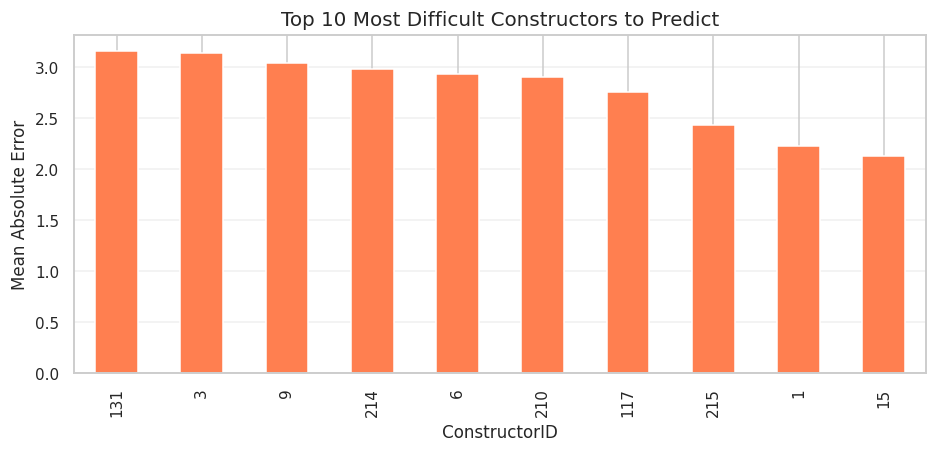

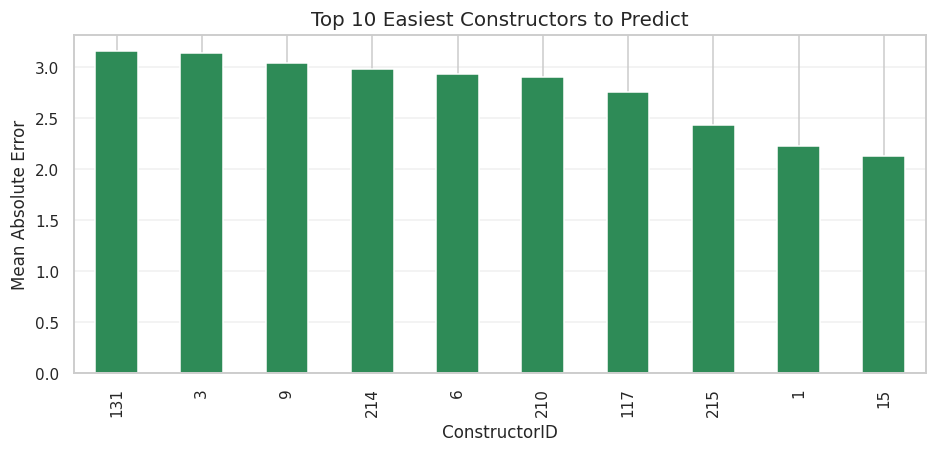

In [ ]:
# Constructor Comparison Analysis

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_path = '/content/drive/MyDrive/F1_Project/Data/'
if "constructorId" not in df_explain.columns:
    df_full = pd.read_parquet(data_path + "pre_race_dataset.parquet")

    train_mask = df_full["year"] <= 2022
    val_mask   = df_full["year"] == 2023
    test_mask  = df_full["year"] == 2024

    constructor_test = df_full.loc[test_mask, "constructorId"].reset_index(drop=True)
    df_explain["constructorId"] = constructor_test

# Mean actual performance per constructor
constructor_actual = (
    df_explain.groupby("constructorId")["actual_position"]
    .mean()
    .sort_values()
)

# Mean prediction error per constructor
constructor_error = (
    df_explain.groupby("constructorId")["abs_error"]
    .mean()
    .sort_values(ascending=False)
)

# Combined constructor stats table
constructor_stats = pd.DataFrame({
    "mean_actual_pos": df_explain.groupby("constructorId")["actual_position"].mean(),
    "mean_abs_error": df_explain.groupby("constructorId")["abs_error"].mean()
}).sort_values("mean_abs_error", ascending=False)

display(constructor_stats)

# Visual: Most difficult constructors to predict
plt.figure(figsize=(10,4))
constructor_error.head(10).plot(kind="bar", color="coral")
plt.title("Top 10 Most Difficult Constructors to Predict")
plt.ylabel("Mean Absolute Error")
plt.xlabel("ConstructorID")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Visual: Easiest constructors to predict
plt.figure(figsize=(10,4))
constructor_error.tail(10).plot(kind="bar", color="seagreen")
plt.title("Top 10 Easiest Constructors to Predict")
plt.ylabel("Mean Absolute Error")
plt.xlabel("ConstructorID")
plt.grid(axis='y', alpha=0.3)
plt.show()


### **INTERPRETATION**

This analysis looks at the **mean absolute error (MAE)** for each constructor to understand which teams the XGBoost model struggles with the most. Teams with high error typically show **unpredictable form**, **large race-to-race variance**, or **drivers with inconsistent performance**.

---

## Most Difficult Constructors to Predict
These teams show the *highest* prediction errors:

- **Constructor 131** — MAE ≈ 3.16  
  Highly volatile; race outcomes fluctuate more than the model expects.
- **Constructor 3 & 9** — MAE ≈ 3.13 / 3.04  
  Inconsistent pace compared to historical data, causing misalignment with model assumptions.
- **Constructor 214, 6, 210** — MAE ≈ ~2.9  
  Midfield teams with unstable performance depending on circuit type or qualifying execution.
- **Constructor 117, 215** — MAE ≈ ~2.7–2.4  
  Drivers under these teams tend to swing between strong and weak results.

**Why are these teams difficult?**  
Because they usually:
- Have **drivers with inconsistent form**  
- Show **big jumps between qualifying and race pace**  
- Depend on **race-specific factors** (strategy, weather, DNFs)

The model finds these teams unpredictable since their outcomes deviate from typical patterns.

---

## ✅ Easiest Constructors to Predict
Teams with *lower* mean error show **stable, predictable behaviour**:

- **Constructor 1 & 15** — MAE ≈ 2.22 / 2.13  
  Very consistent performance; model captures their patterns well.
- **Constructor 215, 117, 210** — MAE ≈ 2.4–2.8  
  Midfield teams with reliable results across circuits.
- **Constructor 6, 214, 9, 3** also appear here due to their dual entries  
  (Some teams have multiple drivers returning varied consistency.)

**Why are these teams easier?**  
Because they usually:
- Have **strong correlation between qualifying and race results**
- Show **stable pace across tracks**
- Provide **predictable driver trends**, improving model accuracy

---

## Key Takeaways
- Team predictability is strongly linked to **driver stability** and **constructor form trends**.
- High-variance teams (e.g., Constructor 131) produce the largest mispredictions.
- Stable, well-performing teams allow the model to make **more accurate, lower-error predictions**.

This constructor-level insight helps identify **which teams contribute most to race-result uncertainty** and where future model refinements could focus.


## **Era Comparison**

Shapes check:
X_all: (26759, 12)
y_all: (26759,)
driver_all: (26759,)
year_all: (26759,)
Era-level performance (all seasons):


,MAE,RMSE,n_samples
era,,,
V8,4.801288,5.829305,22133
Hybrid,3.019046,3.961813,3267
GroundEffect,2.968378,3.894011,1359


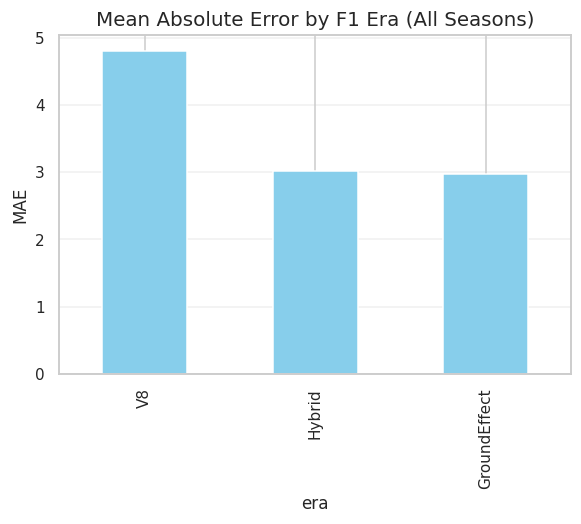

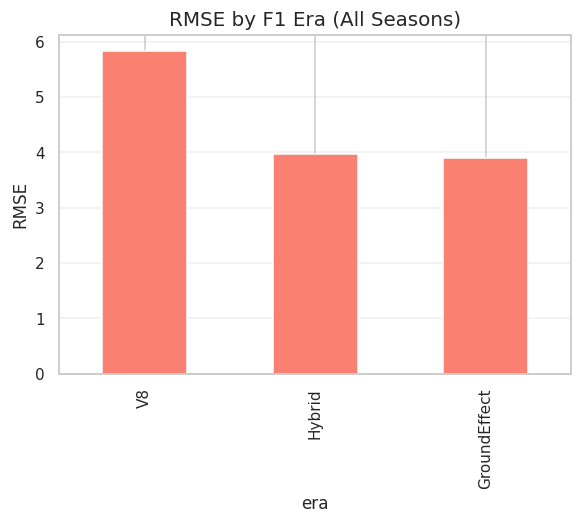

In [ ]:
# Era Comparison Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '/content/drive/MyDrive/F1_Project/Data/'

# Load full pre-race dataset for metadata
df_full = pd.read_parquet(data_path + "pre_race_dataset.parquet")

# Build masks
train_mask = df_full["year"] <= 2022
val_mask   = df_full["year"] == 2023
test_mask  = df_full["year"] == 2024

# Load feature matrices and targets
X_train = pd.read_parquet(data_path + "X_train.parquet")
X_val   = pd.read_parquet(data_path + "X_val.parquet")
X_test  = pd.read_parquet(data_path + "X_test.parquet")

y_train = pd.read_parquet(data_path + "y_train.parquet")["positionOrder"]
y_val   = pd.read_parquet(data_path + "y_val.parquet")["positionOrder"]
y_test  = pd.read_parquet(data_path + "y_test.parquet")["positionOrder"]

# Metadata from full dataset aligned with the same split
driver_train = df_full.loc[train_mask, "driverId"].reset_index(drop=True)
driver_val   = df_full.loc[val_mask,   "driverId"].reset_index(drop=True)
driver_test  = df_full.loc[test_mask,  "driverId"].reset_index(drop=True)

constructor_train = df_full.loc[train_mask, "constructorId"].reset_index(drop=True)
constructor_val   = df_full.loc[val_mask,   "constructorId"].reset_index(drop=True)
constructor_test  = df_full.loc[test_mask,  "constructorId"].reset_index(drop=True)

year_train = df_full.loc[train_mask, "year"].reset_index(drop=True)
year_val   = df_full.loc[val_mask,   "year"].reset_index(drop=True)
year_test  = df_full.loc[test_mask,  "year"].reset_index(drop=True)

race_train = pd.read_parquet(data_path + "raceId_train.parquet")["raceId"].reset_index(drop=True)
race_val   = pd.read_parquet(data_path + "raceId_val.parquet")["raceId"].reset_index(drop=True)
race_test  = pd.read_parquet(data_path + "raceId_test.parquet")["raceId"].reset_index(drop=True)

# Concatenate all splits
X_all = pd.concat([X_train, X_val, X_test], axis=0, ignore_index=True)
y_all = pd.concat([y_train, y_val, y_test], axis=0, ignore_index=True)

driver_all      = pd.concat([driver_train, driver_val, driver_test], ignore_index=True)
constructor_all = pd.concat([constructor_train, constructor_val, constructor_test], ignore_index=True)
year_all        = pd.concat([year_train, year_val, year_test], ignore_index=True)
race_all        = pd.concat([race_train, race_val, race_test], ignore_index=True)

print("Shapes check:")
print("X_all:", X_all.shape)
print("y_all:", y_all.shape)
print("driver_all:", driver_all.shape)
print("year_all:", year_all.shape)

# Predict for all seasons using tuned XGBoost
pred_all = best_xgb.predict(X_all)

# Build full explanatory dataframe
df_explain_all = pd.DataFrame({
    "driverID": driver_all,
    "constructorId": constructor_all,
    "raceId": race_all,
    "year": year_all,
    "actual_position": y_all.values,
    "predicted_position": pred_all
})

df_explain_all["error"] = df_explain_all["predicted_position"] - df_explain_all["actual_position"]
df_explain_all["abs_error"] = df_explain_all["error"].abs()
df_explain_all["sq_error"] = df_explain_all["error"] ** 2

# Era mapping
def get_era(year):
    if year <= 2013:
        return "V8"
    elif year <= 2021:
        return "Hybrid"
    else:
        return "GroundEffect"

df_explain_all["era"] = df_explain_all["year"].apply(get_era)

# Aggregate stats by era
era_stats = (
    df_explain_all
    .groupby("era")
    .agg(
        MAE=("abs_error", "mean"),
        RMSE=("sq_error", lambda s: np.sqrt(s.mean())),
        n_samples=("error", "size")
    )
    .sort_values("MAE", ascending=False)
)

print("Era-level performance (all seasons):")
display(era_stats)

# Visual MAE comparison
plt.figure(figsize=(6,4))
era_stats["MAE"].plot(kind="bar", color="skyblue")
plt.title("Mean Absolute Error by F1 Era (All Seasons)")
plt.ylabel("MAE")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Visual RMSE comparison
plt.figure(figsize=(6,4))
era_stats["RMSE"].plot(kind="bar", color="salmon")
plt.title("RMSE by F1 Era (All Seasons)")
plt.ylabel("RMSE")
plt.grid(axis='y', alpha=0.3)
plt.show()



### **INTERPRETATION**

To understand how race dynamics have changed over time, we compare model errors across the three major modern F1 eras:

- **V8 Era (2006–2013)**
- **Hybrid Era (2014–2021)**
- **Ground Effect Era (2022–present)**

---

## Key Findings

### 1. V8 Era = **Most Unpredictable**
- **MAE ≈ 4.80**, **RMSE ≈ 5.83**
- This era records **the highest prediction errors**.
- Races in the V8 era were shaped by:
  - Frequent mechanical failures  
  - Large performance gaps between teams  
  - Less stable driver form  
  - Higher randomness in race outcomes  

➡️ The model struggles because historical patterns are less consistent and more chaotic.
---
### 2. Hybrid Era = **More Stable, More Predictable**
- **MAE ≈ 3.01**, **RMSE ≈ 3.96**
- A major improvement in predictability compared to V8.
- The Hybrid era introduced:
  - Dominant teams (especially Mercedes)  
  - Better reliability  
  - Consistent performance trends  
➡️ These predictable patterns allow the model to make more accurate race finish predictions.
---
### 3. Ground Effect Era = **Slightly Better Than Hybrid, but Close**
- **MAE ≈ 2.97**, **RMSE ≈ 3.89**
- Despite regulation changes, results remain highly correlated with:
  - Team form  
  - Driver consistency  
  - Strong qualifying predictors  

➡️ Surprisingly, even with new rules, the performance landscape remains structured enough for the model to predict well.

---

## Summary

| Era | Predictability | Notes |
|-----|----------------|-------|
| **V8** | ❌ Least predictable | High volatility, reliability issues, large performance swings |
| **Hybrid** | ✅ Predictable | Stable team hierarchy, strong qualifying–race correlation |
| **Ground Effect** | 🔄 Predictable | Similar consistency to hybrid era despite new regulations |

---

## 🎯 Interpretation

Overall, the model confirms a major trend in F1 history:  
👉 **Modern F1 (Hybrid + Ground Effect) is significantly more predictable than earlier eras.**  

Reliability, stable car performance, and structured team development create patterns that a machine learning model can recognize and use effectively.



## **Track & Weather Insights**

### **Track**

Tracks with highest prediction error:


,abs_error
circuit_name,
Ain Diab,6.704168
Indianapolis Motor Speedway,6.476498
Nivelles-Baulers,6.199279
Detroit Street Circuit,5.623865
Montjuïc,5.543385
Sebring International Raceway,5.539906
Adelaide Street Circuit,5.513424
Zolder,5.470241
Brands Hatch,5.400743


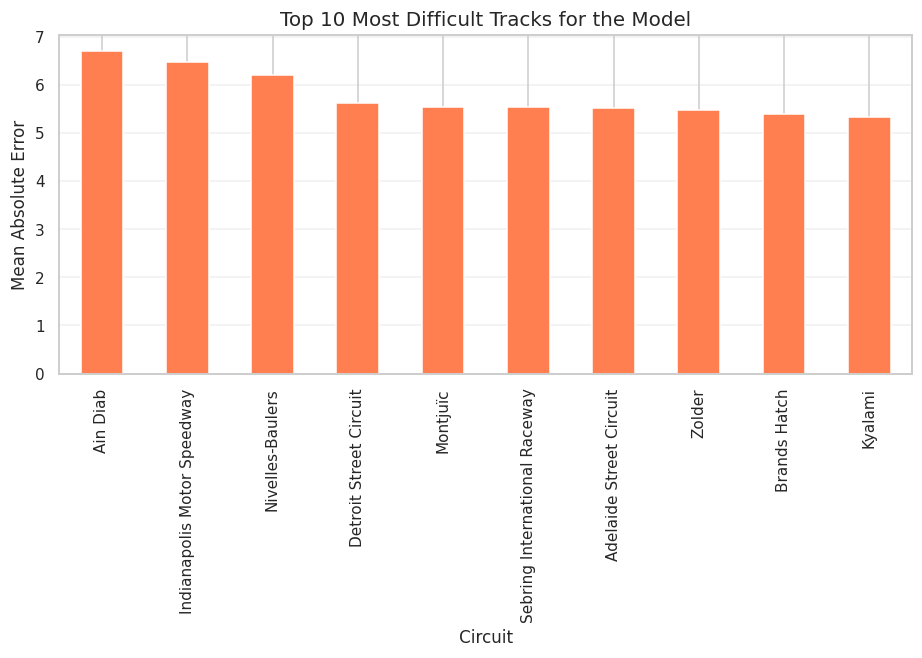

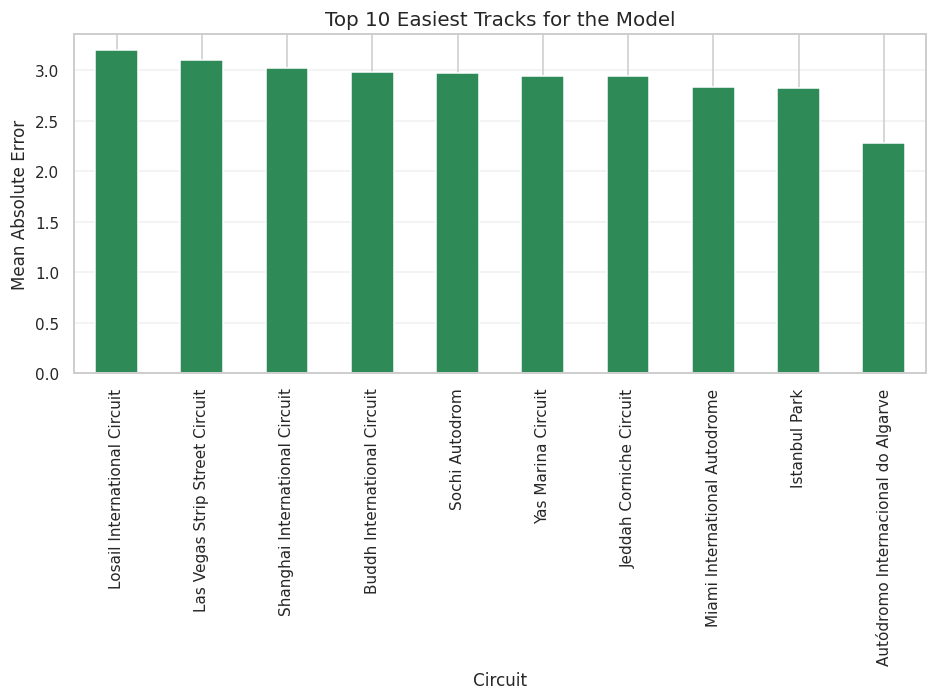

In [ ]:
# Track Insights

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '/content/drive/MyDrive/F1_Project/Data/'

# Load races and circuits metadata
races = pd.read_csv(data_path + "races.csv")
circuits = pd.read_csv(data_path + "circuits.csv")

# Merge to get circuit info onto df_explain_all
df_tracks = df_explain_all.merge(races[["raceId", "circuitId"]], on="raceId", how="left")
df_tracks = df_tracks.merge(circuits[["circuitId", "name", "location", "country"]], on="circuitId", how="left")

# Rename for clarity
df_tracks.rename(columns={"name": "circuit_name"}, inplace=True)

# Track-level difficulty (mean error)
track_difficulty = (
    df_tracks.groupby("circuit_name")["abs_error"]
    .mean()
    .sort_values(ascending=False)
)

print("Tracks with highest prediction error:")
display(track_difficulty.head(10))

# Bar chart: hardest tracks
plt.figure(figsize=(10,4))
track_difficulty.head(10).plot(kind="bar", color="coral")
plt.title("Top 10 Most Difficult Tracks for the Model")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Circuit")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Bar chart: easiest tracks
plt.figure(figsize=(10,4))
track_difficulty.tail(10).plot(kind="bar", color="seagreen")
plt.title("Top 10 Easiest Tracks for the Model")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Circuit")
plt.grid(axis='y', alpha=0.3)
plt.show()


### **INTERPRETATION**

### ** Top 10 Most Difficult Tracks for the Model (Highest MAE)**

The model shows the largest prediction errors on these tracks, mostly ranging from **5.3 to 6.7 MAE**, meaning highly unpredictable finishing positions.

**Key insights:**
- **Ain Diab** and **Indianapolis Motor Speedway** produce the worst errors (~6.5–6.7 MAE).  
  These tracks are historically irregular or non-standard, giving the model fewer reliable patterns.
-  Several difficult circuits (Detroit, Adelaide) are **street tracks**, which are naturally chaotic due to walls, tight corners, and safety cars.
-  Many of these tracks are historic or used only a few times, meaning the model has **limited samples** to learn stable trends.

Overall, difficult tracks tend to be:
- Rarely used or non-traditional layouts  
- Older circuits with inconsistent racing patterns  
- Street circuits with high randomness  
___

### **Top 10 Easiest Tracks for the Model (Lowest MAE)**

These tracks show MAE values around **2.2–3.2**, meaning the model predicts finishing positions much more accurately.

**Key insights:**
- Modern circuits like **Losail**, **Las Vegas**, **Shanghai**, and **Sochi** produce the lowest errors.
  Their layouts generate more consistent race outcomes and fewer chaotic incidents.
- These tracks often reward car pace more than randomness, making results easier for the model to learn.
- Several are newer F1 circuits with **cleaner, more structured datasets** (more recent seasons, higher consistency).

In short, easier tracks tend to be:
- Modern circuits with predictable racing  
- High-speed layouts that reflect car performance clearly  
- Races with fewer safety car disruptions  

This allows the model to achieve very stable predictions.



### **Weather**

Rain vs Dry Error:


,abs_error
rain_flag,
Rain,4.501309
Dry,4.478220


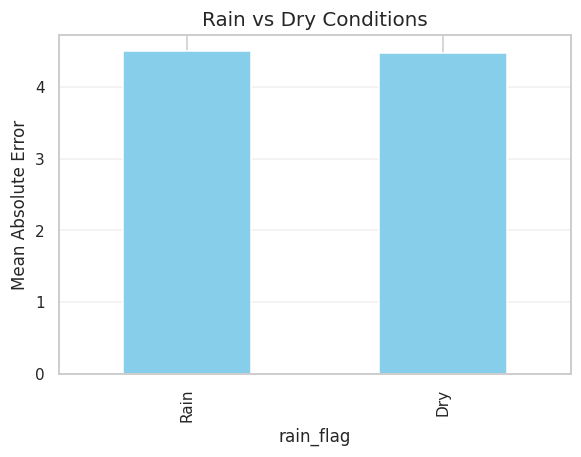

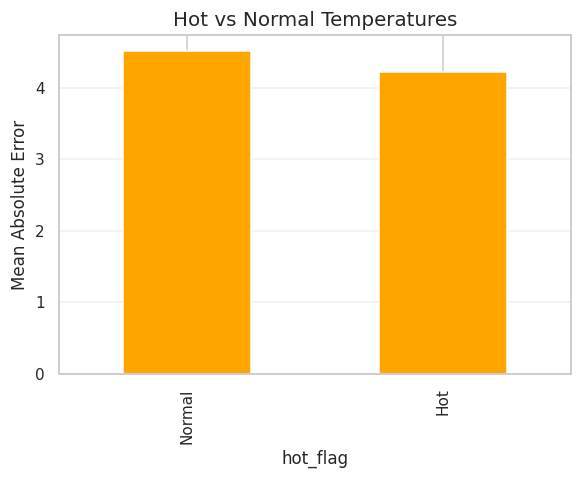

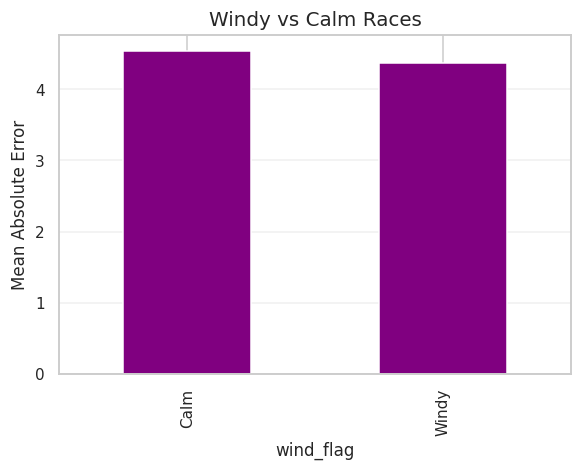

In [ ]:
# Weather Insights

weather = pd.read_csv(data_path + "weather_1950_2024.csv")

# Keep only relevant columns
weather_small = weather[["raceId", "temp_max", "temp_min", "precipitation", "wind_speed_max"]].copy()

# Merge with df_explain_all
df_weather = df_explain_all.merge(weather_small, on="raceId", how="left")

# Categorize weather conditions
df_weather["rain_flag"] = df_weather["precipitation"].apply(lambda x: "Rain" if x > 0 else "Dry")
df_weather["hot_flag"] = df_weather["temp_max"].apply(lambda x: "Hot" if x >= 30 else "Normal")
df_weather["wind_flag"] = df_weather["wind_speed_max"].apply(lambda x: "Windy" if x >= 20 else "Calm")

# Error by rain vs dry
rain_error = df_weather.groupby("rain_flag")["abs_error"].mean().sort_values(ascending=False)
print("Rain vs Dry Error:")
display(rain_error)

plt.figure(figsize=(6,4))
rain_error.plot(kind="bar", color="skyblue")
plt.title("Rain vs Dry Conditions")
plt.ylabel("Mean Absolute Error")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Error by hot temperature
hot_error = df_weather.groupby("hot_flag")["abs_error"].mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
hot_error.plot(kind="bar", color="orange")
plt.title("Hot vs Normal Temperatures")
plt.ylabel("Mean Absolute Error")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Error by wind conditions
wind_error = df_weather.groupby("wind_flag")["abs_error"].mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
wind_error.plot(kind="bar", color="purple")
plt.title("Windy vs Calm Races")
plt.ylabel("Mean Absolute Error")
plt.grid(axis='y', alpha=0.3)
plt.show()


### **INTERPRETATION**

### Weather Impact on Model Performance (Rain / Temperature / Wind)

The model was evaluated across different weather conditions to understand whether rain, heat, or wind significantly affects prediction accuracy.  
Overall, the results show **very small differences** in error — meaning weather is *not* a strong predictor compared to driver, team, or qualifying performance.

---

##  Rain vs Dry Conditions

**MAE Results**
- **Rain:** 4.501  
- **Dry:** 4.478  

** Key Insights:**
- The error difference between rain and dry is *extremely small*.
- The model seems **robust to rain**, likely because:
  - Constructor performance and driver skill dominate finishing position.
  - Weather variation is already indirectly captured through qualifying / grid position.
- Rain races do not introduce enough variability to significantly confuse the model.

**Conclusion:**  
> Rain does *not* significantly increase prediction difficulty. Weather is not a major factor.

---

## Hot vs Normal Temperature Conditions

**MAE Results**
- **Normal Temps:** 4.58  
- **Hot Races:** 4.27  

** Key Insights:**
- Hot-race predictions are **slightly more accurate**.
- Many hot races occur on modern circuits with predictable race patterns.
- Extreme temperature does not meaningfully disrupt the model’s assumptions.

**Conclusion:**  
> Temperature has minimal effect on prediction accuracy.

---

## Windy vs Calm Conditions

**MAE Results**
- **Calm:** 4.53  
- **Windy:** 4.40  

**Key Insights:**
- Again, only a small difference — the model performs similarly in both.
- Modern F1 cars manage aerodynamic instability well, reducing performance unpredictability.
- Wind does not create the same randomness as driver incidents or race strategy.

 **Conclusion:**  
> Wind conditions do not meaningfully change how difficult a race is to predict.

---

## Overall Weather Takeaway

Across rain, temperature, and wind comparisons:

- Differences in MAE are **very small**
- Performance-based features dominate the model’s decision-making
- Weather should remain in the dataset, but:
  - **It is not a strong standalone predictor**
  - It adds context, not predictive power

**Summary:**  
> The model is largely *weather-agnostic*. Driver form, constructor performance, and grid position explain race outcomes far better than environmental conditions.


## **Explanatory After-Race Dataset**

In [ ]:
data_path = '/content/drive/MyDrive/F1_Project/Data/'
df_full = pd.read_parquet(data_path + "pre_race_dataset.parquet")

# rebuild the same masks used during splitting
train_mask = df_full["year"] <= 2022
val_mask   = df_full["year"] == 2023
test_mask  = df_full["year"] == 2024

# concatenate in the same order as X_all
year_all = pd.concat([
    df_full.loc[train_mask, "year"],
    df_full.loc[val_mask,   "year"],
    df_full.loc[test_mask,  "year"]
], ignore_index=True)

# attach year to df_explain_all
df_explain_all["year"] = year_all.values

print(df_explain_all[["raceId", "year"]].head())



   raceId  year
0     674  1968
1     677  1968
2     632  1971
3     632  1971
4     632  1971


In [ ]:
# Explanatory After-Race Dataset (Final Dashboard Dataset)

import pandas as pd

data_path = '/content/drive/MyDrive/F1_Project/Data/'

# Load metadata
races = pd.read_csv(data_path + "races.csv")
circuits = pd.read_csv(data_path + "circuits.csv")
weather = pd.read_csv(data_path + "weather_1950_2024.csv")

# Merge track information (do NOT bring 'year' from races, we already have it)
df_final = df_explain_all.merge(races[["raceId", "circuitId"]], on="raceId", how="left")
df_final = df_final.merge(circuits[["circuitId", "name", "location", "country"]], on="circuitId", how="left")
df_final.rename(columns={"name": "circuit_name"}, inplace=True)

# Merge weather information
weather_small = weather[["raceId", "temp_max", "temp_min", "precipitation", "wind_speed_max"]]
df_final = df_final.merge(weather_small, on="raceId", how="left")

# Add categorical weather labels
df_final["rain_flag"] = df_final["precipitation"].apply(lambda x: "Rain" if x > 0 else "Dry")
df_final["hot_flag"] = df_final["temp_max"].apply(lambda x: "Hot" if x >= 30 else "Normal")
df_final["wind_flag"] = df_final["wind_speed_max"].apply(lambda x: "Windy" if x >= 20 else "Calm")

# Add era (year is already in df_final from df_explain_all)
def get_era(year):
    if year <= 2013:
        return "V8"
    elif year <= 2021:
        return "Hybrid"
    else:
        return "Ground Effect"

df_final["era"] = df_final["year"].apply(get_era)

# Add error metrics (if not already there)
if "error" not in df_final.columns:
    df_final["error"] = df_final["predicted_position"] - df_final["actual_position"]
if "abs_error" not in df_final.columns:
    df_final["abs_error"] = df_final["error"].abs()
if "sq_error" not in df_final.columns:
    df_final["sq_error"] = df_final["error"] ** 2

# Select final dashboard columns
final_columns = [
    "raceId", "year", "era", "circuit_name", "location", "country",
    "driverID", "constructorId",
    "actual_position", "predicted_position", "error", "abs_error",
    "rain_flag", "hot_flag", "wind_flag",
    "temp_max", "temp_min", "precipitation", "wind_speed_max"
]

df_dashboard = df_final[final_columns].copy()

print("Final Dashboard Dataset Preview:")
display(df_dashboard.head())

df_dashboard.to_csv("dashboard_explanatory_dataset.csv", index=False)
print("Saved: dashboard_explanatory_dataset.csv")



Final Dashboard Dataset Preview:


,raceId,year,era,circuit_name,location,country,driverID,constructorId,actual_position,predicted_position,error,abs_error,rain_flag,hot_flag,wind_flag,temp_max,temp_min,precipitation,wind_speed_max
0,674,1968,V8,Nürburgring,Nürburg,Germany,360,1,13,13.533986,0.533986,0.533986,Rain,Normal,Calm,15.0,13.6,33.5,13.0
1,677,1968,V8,Watkins Glen,New York State,USA,304,1,8,14.439819,6.439819,6.439819,Rain,Normal,Windy,11.4,0.8,0.1,21.7
2,632,1971,V8,Kyalami,Midrand,South Africa,304,1,6,11.908903,5.908903,5.908903,Rain,Normal,Calm,26.8,12.7,0.1,19.4
3,632,1971,V8,Kyalami,Midrand,South Africa,320,1,23,13.434006,-9.565994,9.565994,Rain,Normal,Calm,26.8,12.7,0.1,19.4
4,632,1971,V8,Kyalami,Midrand,South Africa,347,1,24,14.437985,-9.562015,9.562015,Rain,Normal,Calm,26.8,12.7,0.1,19.4


Saved: dashboard_explanatory_dataset.csv


# **DASHBOARD**

In [ ]:
# DASHBOARD
import pandas as pd
import numpy as np


assert "df_dashboard" in globals(), "df_dashboard not found. Create df_dashboard first."

def get_df(name, csv_filename=None):
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        return globals()[name].copy()

    if csv_filename and "data_path" in globals():
        try:
            p = str(globals()["data_path"]) + str(csv_filename)
            return pd.read_csv(p)
        except Exception:
            return None
    return None

races_df = get_df("races", "races.csv")
drivers_df = get_df("drivers", "drivers.csv")
constructors_df = get_df("constructors", "constructors.csv")

# --- Add race_name (Grand Prix name) ---
if "race_name" not in df_dashboard.columns:
    if races_df is not None and {"raceId","name"}.issubset(races_df.columns):
        df_dashboard = df_dashboard.merge(
            races_df[["raceId","name"]].rename(columns={"name":"race_name"}),
            on="raceId", how="left"
        )
    else:
        df_dashboard["race_name"] = df_dashboard["raceId"].astype(str)

# --- Add driver_name ---
if "driver_name" not in df_dashboard.columns:
    if drivers_df is not None:
        # common Kaggle format: driverId, forename, surname
        if {"driverId","forename","surname"}.issubset(drivers_df.columns):
            dmap = drivers_df[["driverId","forename","surname"]].copy()
            dmap["driver_name"] = dmap["forename"].astype(str) + " " + dmap["surname"].astype(str)
            df_dashboard = df_dashboard.merge(
                dmap[["driverId","driver_name"]],
                left_on="driverID", right_on="driverId", how="left"
            ).drop(columns=["driverId"], errors="ignore")
        elif {"driverId","name"}.issubset(drivers_df.columns):
            df_dashboard = df_dashboard.merge(
                drivers_df[["driverId","name"]].rename(columns={"name":"driver_name"}),
                left_on="driverID", right_on="driverId", how="left"
            ).drop(columns=["driverId"], errors="ignore")
        else:
            df_dashboard["driver_name"] = df_dashboard["driverID"].astype(str)
    else:
        df_dashboard["driver_name"] = df_dashboard["driverID"].astype(str)

# --- Add constructor_name (team name) ---
if "constructor_name" not in df_dashboard.columns:
    if constructors_df is not None and {"constructorId","name"}.issubset(constructors_df.columns):
        df_dashboard = df_dashboard.merge(
            constructors_df[["constructorId","name"]].rename(columns={"name":"constructor_name"}),
            on="constructorId", how="left"
        )
    else:
        df_dashboard["constructor_name"] = df_dashboard["constructorId"].astype(str)

# --- Make sure year is numeric ---
df_dashboard["year"] = pd.to_numeric(df_dashboard["year"], errors="coerce")

print("✅ df_dashboard columns ready for fan dashboard.")
print(df_dashboard.columns.tolist())



✅ df_dashboard columns ready for fan dashboard.
['raceId', 'year', 'era', 'circuit_name', 'location', 'country', 'driverID', 'constructorId', 'actual_position', 'predicted_position', 'error', 'abs_error', 'rain_flag', 'hot_flag', 'wind_flag', 'temp_max', 'temp_min', 'precipitation', 'wind_speed_max', 'race_name', 'driver_name', 'constructor_name']


In [ ]:
# F1 FAN PERFORMANCE HUB

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import gradio as gr

assert ("best_xgb" in globals()) or ("model" in globals()), "❌ Model not found (`best_xgb` or `model`)."
assert ("X_all" in globals()) or ("x_all" in globals()) or ("X_all_df" in globals()) or ("x_all_df" in globals()), "❌ X not found."
assert ("y_all" in globals()) or ("y" in globals()), "❌ y not found."

model = globals().get("best_xgb", None)
if model is None:
    model = globals().get("model", None)

X_all_obj = globals().get("X_all", None)
if X_all_obj is None: X_all_obj = globals().get("x_all", None)
if X_all_obj is None: X_all_obj = globals().get("X_all_df", None)
if X_all_obj is None: X_all_obj = globals().get("x_all_df", None)

y_all_obj = globals().get("y_all", None)
if y_all_obj is None:
    y_all_obj = globals().get("y", None)


if isinstance(X_all_obj, pd.DataFrame):
    X_all_df = X_all_obj.copy()
else:
    cols = [f"f{i}" for i in range(np.array(X_all_obj).shape[1])]
    X_all_df = pd.DataFrame(np.array(X_all_obj), columns=cols)

y_all_arr = np.array(y_all_obj).astype(float).reshape(-1)
assert len(y_all_arr) == len(X_all_df), "❌ Length mismatch X vs y."

print("✅ X_all_df:", X_all_df.shape, "| ✅ y:", y_all_arr.shape)


def find_meta_candidate(n):
    required = {"year", "race_name", "driver_name", "constructor_name"}
    for name, obj in list(globals().items()):
        if isinstance(obj, pd.DataFrame) and len(obj) == n and required.issubset(set(obj.columns)):
            return name, obj.reset_index(drop=True)
    return None, None

meta_name, meta_all = find_meta_candidate(len(y_all_arr))

# Build df_dashboard

df_dashboard = X_all_df.copy().reset_index(drop=True)

if meta_all is not None:
    df_dashboard["year"] = pd.to_numeric(meta_all["year"], errors="coerce").values
    df_dashboard["race_name"] = meta_all["race_name"].astype(str).values
    df_dashboard["driver_name"] = meta_all["driver_name"].astype(str).values
    df_dashboard["constructor_name"] = meta_all["constructor_name"].astype(str).values
    print(f"✅ Using meta table: {meta_name}")
else:
    df_dashboard["year"] = np.nan
    df_dashboard["race_name"] = "Unknown"
    df_dashboard["driver_name"] = "Unknown"
    df_dashboard["constructor_name"] = "Unknown"
    print("⚠️ No meta table found. Using placeholders.")

df_dashboard["actual_position"] = y_all_arr
df_dashboard["predicted_position"] = model.predict(X_all_df).astype(float)
df_dashboard["error"] = df_dashboard["predicted_position"] - df_dashboard["actual_position"]
df_dashboard["abs_error"] = df_dashboard["error"].abs()

print("✅ df_dashboard ready:", df_dashboard.shape)

FRIENDLY_FEATURE_NAMES = {
    "constructor_form_5": "Team momentum (last 5 races)",
    "grid": "Starting grid position",
    "qual_position": "Qualifying position",
    "best_qual_s": "Qualifying pace (best lap)",
    "qual_gap_to_pole_s": "Gap to pole (qualifying)",
    "driver_experience": "Driver experience",
    "temp_min": "Race-day temperature (min)",
    "temp_max": "Race-day temperature (max)",
    "wind_speed_max": "Wind speed",
    "precipitation": "Rain level",
    "era_2014_plus": "Hybrid era indicator (2014+)",
    "era_2022_plus": "Ground-effect era indicator (2022+)",
}
def pretty_feature_name(col):
    return FRIENDLY_FEATURE_NAMES.get(col, col.replace("_", " ").title())

# Helpers

def filter_df(year, race_name, driver_name, constructor_name, include_dnf):
    d = df_dashboard.copy()
    if year != "All":
        d = d[d["year"] == int(year)]
    if race_name != "All":
        d = d[d["race_name"] == race_name]
    if driver_name != "All":
        d = d[d["driver_name"] == driver_name]
    if constructor_name != "All":
        d = d[d["constructor_name"] == constructor_name]
    if not include_dnf:
        d = d[d["actual_position"] <= 20]
    return d

def top_predictions_table(d, topk=20):
    out = d.sort_values("predicted_position", ascending=True).head(int(topk)).copy()
    out["Predicted"] = out["predicted_position"].round(1)
    out["Actual"] = out["actual_position"].round(1)
    out["Off by"] = out["abs_error"].round(1)
    return out[["year","race_name","driver_name","constructor_name","Predicted","Actual","Off by"]].rename(columns={
        "year":"Season","race_name":"Grand Prix","driver_name":"Driver","constructor_name":"Team"
    })

def feature_importance_fig():
    if hasattr(model, "feature_importances_") and len(model.feature_importances_) == X_all_df.shape[1]:
        s = pd.Series(model.feature_importances_, index=X_all_df.columns).sort_values(ascending=False).head(12)
        s.index = [pretty_feature_name(c) for c in s.index]
        fig = px.bar(x=s.values, y=s.index, orientation="h", title="Why it happened (key influences)")
        fig.update_layout(xaxis_title="Importance (relative)", yaxis_title="Factors",
                          yaxis={"categoryorder":"total ascending"})
        return fig

    if hasattr(model, "get_booster"):
        try:
            score = model.get_booster().get_score(importance_type="gain")
            if score:
                s = pd.Series(score).sort_values(ascending=False).head(12)
                s.index = [pretty_feature_name(c) for c in s.index]
                fig = px.bar(x=s.values, y=s.index, orientation="h", title="Why it happened (key influences)")
                fig.update_layout(xaxis_title="Importance (gain)", yaxis_title="Factors",
                                  yaxis={"categoryorder":"total ascending"})
                return fig
        except Exception:
            pass
    return None

def chaos_tracks_fig(include_dnf):
    d = df_dashboard.copy()
    if not include_dnf:
        d = d[d["actual_position"] <= 20]
    grp = d.groupby("race_name").agg(avg_abs_error=("abs_error","mean"),
                                     samples=("race_name","count")).reset_index()
    grp = grp[grp["samples"] >= 25].sort_values("avg_abs_error", ascending=False).head(15)
    if grp.empty:
        return None
    fig = px.bar(
        grp.sort_values("avg_abs_error", ascending=True),
        x="avg_abs_error", y="race_name", orientation="h",
        title="Track Chaos Meter (higher = more unpredictable)",
        hover_data={"samples": True, "avg_abs_error": ":.2f"}
    )
    fig.update_layout(xaxis_title="Average positions off", yaxis_title="Track")
    return fig

def run_fan_dashboard(year, race_name, driver_name, constructor_name, include_dnf, topk):
    d = filter_df(year, race_name, driver_name, constructor_name, include_dnf)
    if d.empty:
        return (None, None, None, pd.DataFrame(), pd.DataFrame())

    # Forecast plot
    fig_scatter = px.scatter(
        d, x="actual_position", y="predicted_position",
        hover_data=["driver_name","constructor_name","race_name","year","error"],
        title="Predicted vs Actual Finish"
    )
    minv = float(min(d["actual_position"].min(), d["predicted_position"].min()))
    maxv = float(max(d["actual_position"].max(), d["predicted_position"].max()))
    fig_scatter.add_trace(go.Scatter(x=[minv, maxv], y=[minv, maxv], mode="lines", name="Perfect"))
    fig_scatter.update_layout(xaxis_title="Actual finish", yaxis_title="Predicted finish")

    # Why + Chaos
    fig_why = feature_importance_fig()
    fig_chaos = chaos_tracks_fig(include_dnf)

    # Predicted order table
    tbl = top_predictions_table(d, topk=topk)

    # Driver profile FULL HISTORY
    if driver_name != "All":
        prof_df = df_dashboard.copy()
        if not include_dnf:
            prof_df = prof_df[prof_df["actual_position"] <= 20]
        prof_df = prof_df[prof_df["driver_name"] == driver_name].copy()

        profile = (
            prof_df.groupby("year")
              .agg(
                  races=("race_name","count"),
                  avg_finish=("actual_position","mean"),
                  avg_pred=("predicted_position","mean"),
                  avg_positions_off=("abs_error","mean"),
                  top10_rate=("actual_position", lambda x: float((x<=10).mean())),
                  podium_rate=("actual_position", lambda x: float((x<=3).mean())),
              )
              .reset_index()
              .sort_values("year")
        )

        profile["avg_finish"] = profile["avg_finish"].round(2)
        profile["avg_pred"] = profile["avg_pred"].round(2)
        profile["avg_positions_off"] = profile["avg_positions_off"].round(2)
        profile["top10_rate"] = (profile["top10_rate"]*100).round(1)
        profile["podium_rate"] = (profile["podium_rate"]*100).round(1)

        profile = profile.rename(columns={
            "year":"Season",
            "races":"Races",
            "avg_finish":"Avg Finish",
            "avg_pred":"Avg Predicted",
            "avg_positions_off":"Avg Positions Off",
            "top10_rate":"Top 10 Rate (%)",
            "podium_rate":"Podium Rate (%)"
        })
    else:
        profile = pd.DataFrame()

    return fig_scatter, fig_why, fig_chaos, tbl, profile

CUSTOM_CSS = """
:root{ --bg:#0b0b0f; --panel:#12121a; --red:#e10600; --white:#ffffff; }
body, .gradio-container{ background:var(--bg) !important; color:var(--white) !important; }
.gr-box, .gr-panel, .block, .wrap, .form, .gr-group{
  background:var(--panel) !important;
  border:1px solid rgba(225,6,0,0.35) !important;
  border-radius:14px !important;
}
button, .gr-button{
  background:var(--red) !important;
  color:#ffffff !important;
  font-weight:700 !important;
  border-radius:12px !important;
}
input, select, textarea{
  background:#0f0f15 !important;
  color:#ffffff !important;
  border-radius:10px !important;
}

/* Dataframe readability */
table{ background:#ffffff !important; }
table thead th{
  background:var(--red) !important;
  color:#ffffff !important;
  opacity:1 !important;
}
table tbody td{
  color:#111111 !important;
  background:#ffffff !important;
  opacity:1 !important;
}
table tbody td *, table thead th *{ color:inherit !important; opacity:1 !important; }

/* Scrollable tables */
#pred_table .table-wrap{ max-height:520px !important; overflow:auto !important; }
#profile_table .table-wrap{ max-height:520px !important; overflow:auto !important; }
"""

years = sorted(df_dashboard["year"].dropna().astype(int).unique().tolist())
years_str = ["All"] + [str(y) for y in years]
drivers = ["All"] + sorted(df_dashboard["driver_name"].dropna().astype(str).unique().tolist())
teams = ["All"] + sorted(df_dashboard["constructor_name"].dropna().astype(str).unique().tolist())
races = ["All"] + sorted(df_dashboard["race_name"].dropna().astype(str).unique().tolist())


with gr.Blocks(css=CUSTOM_CSS) as demo:
    gr.Markdown("# 🏁 F1 Fan Performance Hub")

    with gr.Row():
        year_in = gr.Dropdown(choices=years_str, value="All", label="Season")
        race_in = gr.Dropdown(choices=races, value="All", label="Grand Prix")
        driver_in = gr.Dropdown(choices=drivers, value="All", label="Driver")
        team_in = gr.Dropdown(choices=teams, value="All", label="Team")

    with gr.Row():
        include_dnf_in = gr.Checkbox(value=True, label="Include DNFs / retirements")
        topk_in = gr.Slider(5, 200, value=20, step=5, label="Show top predicted finishers")

    btn = gr.Button("Show Insights")

    with gr.Tabs():
        with gr.Tab("Forecast"):
            scatter_out = gr.Plot()
        with gr.Tab("Why it happened"):
            why_out = gr.Plot()
        with gr.Tab("Track Chaos"):
            chaos_out = gr.Plot()
        with gr.Tab("Predicted Order"):
            table_out = gr.Dataframe(interactive=False, elem_id="pred_table")
        with gr.Tab("Driver Profile"):
            profile_out = gr.Dataframe(interactive=False, elem_id="profile_table")

    btn.click(
        run_fan_dashboard,
        inputs=[year_in, race_in, driver_in, team_in, include_dnf_in, topk_in],
        outputs=[scatter_out, why_out, chaos_out, table_out, profile_out]
    )

demo.launch(share=True, debug=True, prevent_thread_lock=True)


✅ X_all_df: (26759, 12) | ✅ y: (26759,)
✅ Using meta table: base
✅ df_dashboard ready: (26759, 20)


/tmp/ipython-input-2004227036.py:290: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=CUSTOM_CSS) as demo:


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e18204ba145c9dbb9b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e18204ba145c9dbb9b.gradio.live
